# European electricity price market forecasting

## Overview

- Objective: European electricity price market forecasting
- Target: price
- Type: day ahead (24h)
- Context: This project tackles day-ahead electricity price forecasting in the European power market, using Spain as a case study and the “Energy consumption, generation, prices and weather” dataset from Kaggle. I build a production-style pipeline for 24-hour-ahead price prediction and explore how to flexibly apply different darts models (e.g. XGBoost, LSTM) under various settings. The project also highlights practical issues such as data leakage, non-stationarity, and extreme spikes, and shows basic strategies to handle them in practice.
- Source: https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather

## Datasets

1. energy_dataset: 
   - Power system (actuals by hour)
     - time — Timestamp of the delivery hour (usually ISO 8601). Use UTC internally; handle DST carefully.

     - generation biomass — Electricity generated from biomass, in MW (instantaneous average over the hour).

     - generation fossil brown coal/lignite — Lignite-fired generation, MW.

     - generation fossil coal-derived gas — Coal-gas derived generation, MW.

     - generation fossil gas — Natural gas generation, MW.

     - generation fossil hard coal — Hard/bituminous coal generation, MW.

     - generation fossil oil — Oil-fired generation, MW.

     - generation fossil oil shale — Oil-shale–based generation, MW.

     - generation fossil peat — Peat-fueled generation, MW.

     - generation geothermal — Geothermal generation, MW.

     - generation hydro pumped storage aggregated — Net pumped-storage generation (aggregate), MW (positive = generating).

     - generation hydro pumped storage consumption — Pumped-storage pumping load/consumption, MW (positive = consuming).

     - generation hydro run-of-river and poundage — Run-of-river hydro generation, MW.

     - generation hydro water reservoir — Reservoir hydro generation, MW.

     - generation marine — Tidal/wave (marine) generation, MW.

     - generation nuclear — Nuclear generation, MW.

     - generation other — Other unspecified generation sources, MW.

     - generation other renewable — Other renewables not listed elsewhere (e.g., biomass waste-to-energy if categorized so), MW.

     - generation solar — Solar PV generation, MW.

     - generation waste — Waste-to-energy generation, MW.

     - generation wind offshore — Offshore wind generation, MW.

     - generation wind onshore — Onshore wind generation, MW.

   - Forecasts (known at/ before the forecast time)

     - forecast solar day ahead — Day-ahead solar generation forecast, MW for each hour of the next day (feature; avoid using realized future solar).

     - forecast wind offshore day ahead (your list says “offshore eday ahead”; assume a typo) — Day-ahead offshore wind forecast, MW.

     - forecast wind onshore day ahead — Day-ahead onshore wind forecast, MW.

     - total load forecast — System load forecast made day-ahead or intra-day, MW (feature; do not use future actuals). NB: In this project we treat these operator forecasts as unavailable to the model, so this column is not used as a feature.

     - price day ahead — Day-ahead market price for the delivery hour, EUR/MWh (can be negative). NB: This is the main target of this project, so it is not used as a feature and will be dropped later.

    - Load & price targets
      - total load actual — Realized system load (demand), MW.

      - price actual — Realized/settlement price (if provided; may be balancing or intraday realized), EUR/MWh.

2. Weather dataset (typically hourly, by city/area):
     - dt_iso — Weather observation/forecast timestamp (ISO 8601; confirm whether this is UTC or local from the source).

     - city_name — Name/identifier of the weather location (join key if multiple stations).

     - temp — Air temperature at 2 m, °C.

     - temp_min — Min temperature over the last/next observation window, °C (API-dependent).

     - temp_max — Max temperature over the last/next observation window, °C.

     - pressure — Atmospheric pressure at sea level, hPa.

     - humidity — Relative humidity, %.

     - wind_speed — Wind speed, typically m/s (sometimes km/h; check the data source).

     - wind_deg — Wind direction in degrees (0–360, meteorological).

     - rain_1h — Rainfall volume in the last 1 h, mm.

     - rain_3h — Rainfall volume in the last 3 h, mm.

     - snow_3h — Snowfall volume in the last 3 h, mm (water equivalent).

     - clouds_all — Cloudiness, % (0–100).

     - weather_id — Weather condition code (numeric category).

     - weather_main — High-level weather category (e.g., Rain, Snow).

     - weather_description — Human-readable description (e.g., “light rain”).

     - weather_icon — Icon code string (display-only; not predictive).                                                   

## 0. Set Up

In [1]:
# ===== Standard library =====
import logging
import warnings
from datetime import datetime

# ===== Third-party =====
import holidays
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import optuna
import optuna.visualization as ov
import pandas as pd
import plotly.io as pio
import pytorch_lightning as pl
import seaborn as sns
import torch
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from torch import nn

from optuna.integration import PyTorchLightningPruningCallback
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

# ===== Darts =====
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae, rmse
from darts.models import BlockRNNModel, XGBModel
from darts.utils.likelihood_models import QuantileRegression

# ===== Config & logging =====
warnings.filterwarnings("ignore")
logging.getLogger("darts").setLevel(logging.ERROR)

seed_everything(42, workers=True)

pio.renderers.default = "vscode"
# pio.renderers.default = "notebook_connected"

# display all pandas columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

/home/admin_ml/Jackson/projects/darts/Time-Series-Training/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The StatsForecast module could not be imported. To enable support for the AutoARIMA, AutoETS and Croston models, please consider installing it.
Seed set to 42


In [2]:
# ===== Configuration =====
H = 24
target_cols = ['price actual']
ISSUE_HOUR = 12 # 12:00 PM

## 1. EDA

In [3]:
# ===== Load datasets =====
energy_data = pd.read_csv("/mnt/datasets/energy_dataset.csv", parse_dates=["time"])
weather_data = pd.read_csv("/mnt/datasets/weather_features.csv", parse_dates=["dt_iso"])

### 1.1 Energy dataset

In [4]:
# Overall information
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [5]:
# number of unique 
energy_data.nunique()

time                                           35064
generation biomass                               423
generation fossil brown coal/lignite             956
generation fossil coal-derived gas                 1
generation fossil gas                           8297
generation fossil hard coal                     7266
generation fossil oil                            321
generation fossil oil shale                        1
generation fossil peat                             1
generation geothermal                              1
generation hydro pumped storage aggregated         0
generation hydro pumped storage consumption     3311
generation hydro run-of-river and poundage      1684
generation hydro water reservoir                7029
generation marine                                  1
generation nuclear                              2388
generation other                                 103
generation other renewable                        78
generation solar                              

In [6]:
# Drop null columns, constant columns, useless columns
drop_cols = ["generation fossil coal-derived gas", 
             "generation fossil oil shale", 
             "generation fossil peat", 
             "generation geothermal", 
             "generation hydro pumped storage aggregated", 
             "generation marine", 
             "generation wind offshore", 
             "forecast wind offshore eday ahead",
             "price day ahead",
             "total load forecast"
             ]

energy_data = energy_data.drop(columns=drop_cols)

In [7]:
# Convert time column to datetime type and set it as index
energy_data["time"] = pd.to_datetime(energy_data["time"], utc=True, infer_datetime_format=True).dt.floor("h")
energy_data = energy_data.set_index("time").sort_index()

In [8]:
# duplicated rows
duplicate_rows = energy_data[energy_data.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

Number of duplicate rows: 0


In [9]:
# time continuity check
time_diff = energy_data.index.to_series().diff().dropna()
missing_intervals = time_diff[time_diff != pd.Timedelta(hours=1)]
print(f"Number of missing time intervals: {len(missing_intervals)}")

Number of missing time intervals: 0


In [10]:
# null values
energy_data.isnull().sum()

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
forecast solar day ahead                        0
forecast wind onshore day ahead                 0
total load actual                              36
price actual                                    0
dtype: int64

In [11]:
# total rows
total_rows = energy_data.shape[0]
print(f"Total rows: {total_rows}")

Total rows: 35064


Comparing the total number of the samples, there are only few missing features. We only need to check the target column: total load actual:

In [12]:
# find the missing rows of the target column 'total load actual'
missing_target_rows = energy_data[energy_data["total load actual"].isnull()]
missing_target_rows

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load actual,price actual
time,,,,,,,,,,,,,,,,,,
2015-01-05 11:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3932.0,9258.0,NaN,79.14
2015-01-05 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4236.0,9156.0,NaN,73.95
2015-01-05 13:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4215.0,9072.0,NaN,71.93
2015-01-05 14:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4050.0,8779.0,NaN,71.50
2015-01-05 15:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3728.0,8426.0,NaN,71.85
2015-01-05 16:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3175.0,7946.0,NaN,80.53
2015-01-28 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4136.0,6223.0,NaN,77.62
2015-02-01 06:00:00+00:00,449.0,312.0,4765.0,5269.0,222.0,480.0,980.0,1174.0,7101.0,44.0,75.0,48.0,208.0,3289.0,18.0,3141.0,NaN,16.98
2015-02-01 07:00:00+00:00,453.0,312.0,4938.0,5652.0,288.0,0.0,1031.0,3229.0,7099.0,44.0,75.0,73.0,207.0,3102.0,63.0,3165.0,NaN,19.56


The gaps are scattered across the time range, so we apply a forward fill to impute short gaps and remove any initial missing values.

In [13]:
print(f"total rows: {energy_data.shape[0]}, missing target rows: {missing_target_rows.shape[0]} before imputation:")
energy_data = energy_data.ffill().dropna()
energy_data.isnull().sum()

total rows: 35064, missing target rows: 36 before imputation:


generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
forecast solar day ahead                       0
forecast wind onshore day ahead                0
total load actual                              0
price actual                                   0
dtype: int64

In [14]:
# Overall information after cleaning
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 18 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35064 non-null  float64
 1   generation fossil brown coal/lignite         35064 non-null  float64
 2   generation fossil gas                        35064 non-null  float64
 3   generation fossil hard coal                  35064 non-null  float64
 4   generation fossil oil                        35064 non-null  float64
 5   generation hydro pumped storage consumption  35064 non-null  float64
 6   generation hydro run-of-river and poundage   35064 non-null  float64
 7   generation hydro water reservoir             35064 non-null  float64
 8   generation nuclear                           35064 non-null  float64
 9   generation other         

### 1.2 Weather

In [15]:
# convert dt_iso to datetime
weather_data["time"] = pd.to_datetime(weather_data["dt_iso"], utc=True, infer_datetime_format=True).dt.floor("h")
weather_data = weather_data.drop(columns=["dt_iso"])

# Overall information
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   city_name            178396 non-null  object             
 1   temp                 178396 non-null  float64            
 2   temp_min             178396 non-null  float64            
 3   temp_max             178396 non-null  float64            
 4   pressure             178396 non-null  int64              
 5   humidity             178396 non-null  int64              
 6   wind_speed           178396 non-null  int64              
 7   wind_deg             178396 non-null  int64              
 8   rain_1h              178396 non-null  float64            
 9   rain_3h              178396 non-null  float64            
 10  snow_3h              178396 non-null  float64            
 11  clouds_all           178396 non-null  int64              
 12  we

In [16]:
# number of unique
print("total rows:", weather_data.shape[0])
weather_data.nunique()

total rows: 178396


city_name                  5
temp                   20743
temp_min               18553
temp_max               18591
pressure                 190
humidity                 100
wind_speed                36
wind_deg                 361
rain_1h                    7
rain_3h                   89
snow_3h                   66
clouds_all                97
weather_id                38
weather_main              12
weather_description       43
weather_icon              24
time                   35064
dtype: int64

In [17]:
# for the sake of simplicity, we will temporarily drop objective columns: weather_description 
weather_data = weather_data.drop(columns=["weather_main", "weather_icon", "weather_description"])

In [18]:
# check duplicated rows in different citys

duplicate_rows_weather = weather_data[weather_data.duplicated(subset=['city_name', 'time'])]
print(f"Number of duplicate rows in weather data: {duplicate_rows_weather.shape[0]}")

# drop duplicate rows
weather_data = weather_data.drop_duplicates(subset=['city_name', 'time'])

# Check duplicates again
duplicate_rows_weather_check = weather_data[weather_data.duplicated(subset=['city_name', 'time'])]
print(f"Number of duplicate rows in weather data after dropping duplicates: {duplicate_rows_weather_check.shape[0]}")

Number of duplicate rows in weather data: 3076
Number of duplicate rows in weather data after dropping duplicates: 0


In [19]:
# set time column as index
weather_data = weather_data.set_index("time").sort_index()

# check time continuity for each city
missing_counts = (weather_data
    .groupby('city_name')
    .apply(lambda g: g.index.to_series().diff().dropna().ne(pd.Timedelta('1H')).sum())
)
print(missing_counts)

city_name
 Barcelona    0
Bilbao        0
Madrid        0
Seville       0
Valencia      0
dtype: int64


In [20]:
# null values
weather_data.isnull().sum()

city_name     0
temp          0
temp_min      0
temp_max      0
pressure      0
humidity      0
wind_speed    0
wind_deg      0
rain_1h       0
rain_3h       0
snow_3h       0
clouds_all    0
weather_id    0
dtype: int64

In [21]:
# check object columns in details
object_cols = weather_data.select_dtypes(include=['object']).columns
for col in object_cols:
    print(f"Value counts for column '{col}':")
    print(weather_data[col].value_counts())
    print()

Value counts for column 'city_name':
city_name
Valencia      35064
Seville       35064
Madrid        35064
 Barcelona    35064
Bilbao        35064
Name: count, dtype: int64



In [22]:
# statistical summary
weather_data.describe()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,175320.000000,175320.000000,175320.000000,1.753200e+05,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000
mean,289.707651,288.428433,291.172255,1.070199e+03,68.032307,2.470009,166.724909,0.069308,0.000386,0.004846,24.344057,763.452390
std,8.024910,7.948249,8.613916,6.021769e+03,21.838097,2.095140,116.548788,0.385915,0.007348,0.224547,30.339522,103.125539
min,262.240000,262.240000,262.240000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000
25%,283.830000,282.784586,284.909258,1.013000e+03,53.000000,1.000000,56.000000,0.000000,0.000000,0.000000,0.000000,800.000000
50%,289.150000,288.150000,290.150000,1.018000e+03,72.000000,2.000000,178.000000,0.000000,0.000000,0.000000,16.000000,800.000000
75%,295.240000,294.150000,297.150000,1.022000e+03,87.000000,4.000000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000
max,315.600000,315.150000,321.150000,1.008371e+06,100.000000,133.000000,360.000000,12.000000,2.315000,21.500000,100.000000,804.000000


**Key Findings:**

- Pressure shows both low and extreme high outliers;
- wind speed has a heavy upper tail; 
- rain/snow: Mostly zeros, occasional spikes.. 

We’ll confirm this through visualization and further analysis.

### 1.3 Visualization

#### 1.3.1 energy data visualization

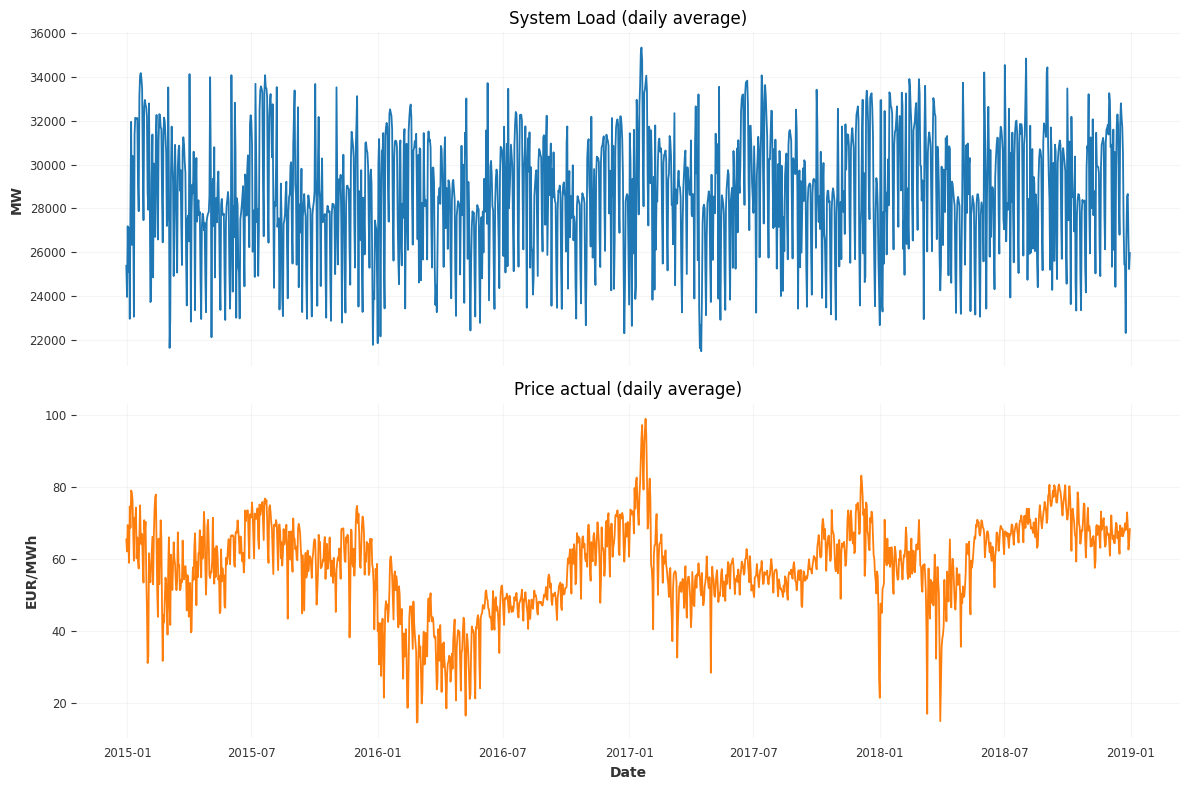

In [23]:
# Load & Price: Overall Trend (Hourly → Daily Mean, Denoised)
daily = energy_data[['total load actual','price actual']].resample('D').mean()

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(daily.index, daily['total load actual'], label='Load (daily mean)', color='tab:blue')
ax[0].set_ylabel('MW')
ax[0].set_title('System Load (daily average)')
ax[0].grid(True, alpha=0.3)

ax[1].plot(daily.index, daily['price actual'], label='Price actual (daily mean)', color='tab:orange')
ax[1].set_ylabel('EUR/MWh')
ax[1].set_title('Price actual (daily average)')
ax[1].grid(True, alpha=0.3)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

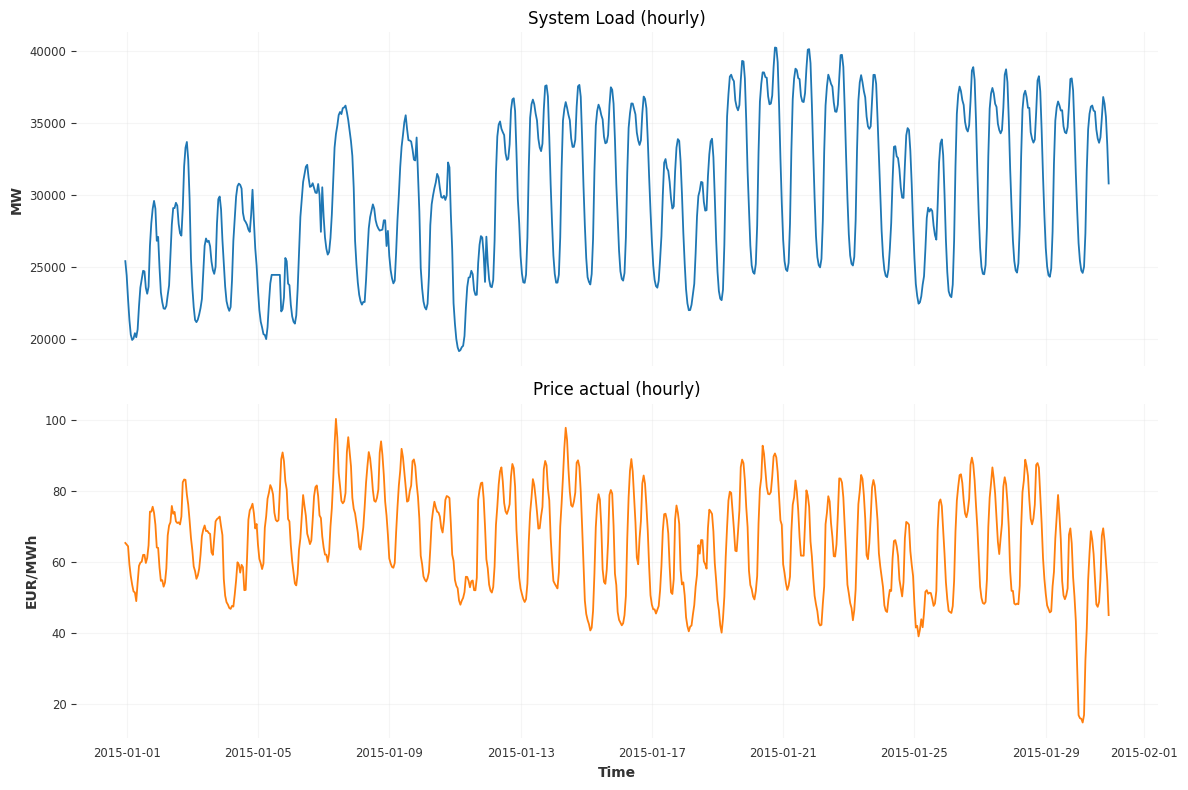

In [24]:
# Hourly Load & Price in a small time window
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(energy_data.index[:24*30], energy_data['total load actual'][:24*30], label='Load (hourly)', color='tab:blue')
ax[0].set_ylabel('MW')
ax[0].set_title('System Load (hourly)')
ax[0].grid(True, alpha=0.3)

ax[1].plot(energy_data.index[:24*30], energy_data['price actual'][:24*30], label='Price actual (hourly)', color='tab:orange')
ax[1].set_ylabel('EUR/MWh')
ax[1].set_title('Price actual (hourly)')
ax[1].grid(True, alpha=0.3)

plt.xlabel('Time')
plt.tight_layout()
plt.show()

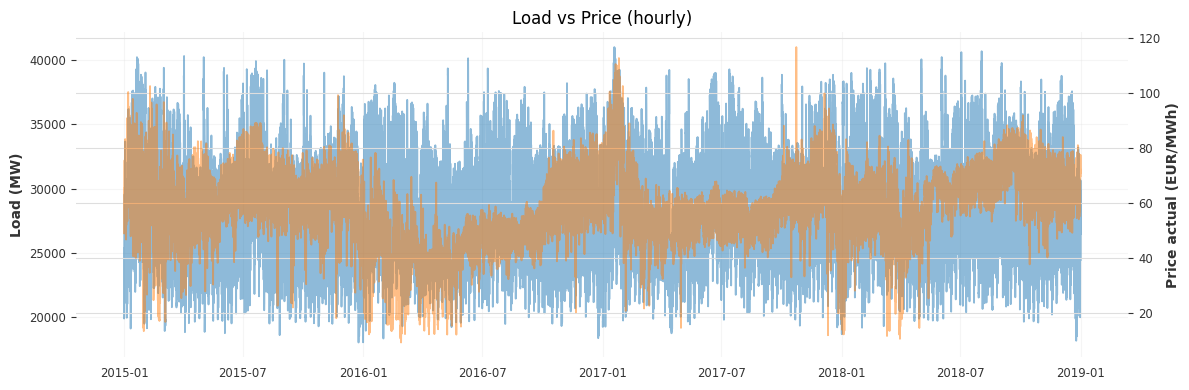

In [25]:
# Load & Price: Dual-Axis View (Hourly Detail)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(energy_data.index, energy_data['total load actual'], alpha=0.5, color='tab:blue')
ax.set_ylabel('Load (MW)')
ax.grid(True, alpha=0.3)
ax2 = ax.twinx()
ax2.plot(energy_data.index, energy_data['price actual'], alpha=0.5, color='tab:orange')
ax2.set_ylabel('Price actual (EUR/MWh)')
ax.set_title('Load vs Price (hourly)')   
plt.tight_layout()
plt.show()


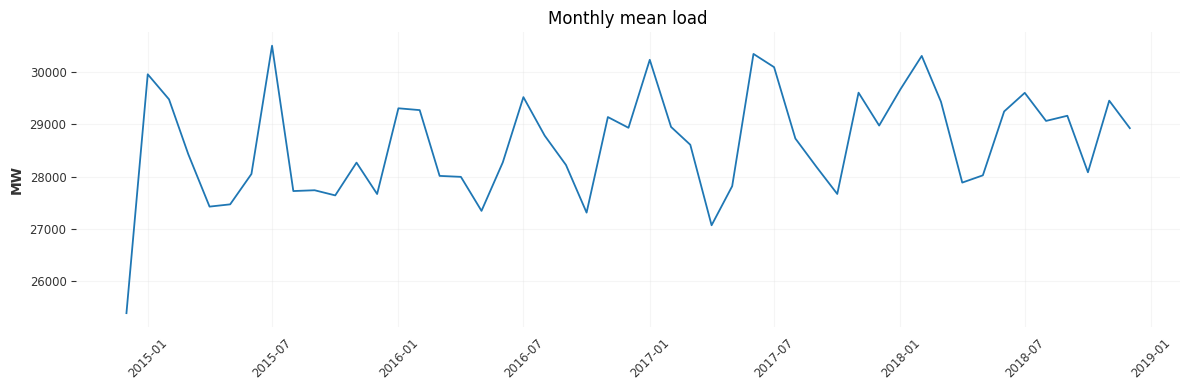

In [26]:
# Seasonality – Monthly

monthly = energy_data['total load actual'].resample('MS').mean()
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(monthly.index, monthly.values, color='tab:blue')
ax.set_title('Monthly mean load')
ax.set_ylabel('MW')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

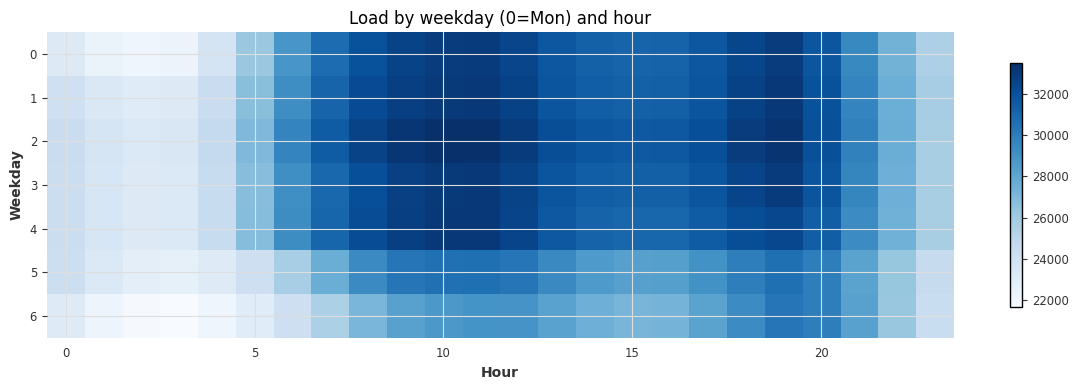

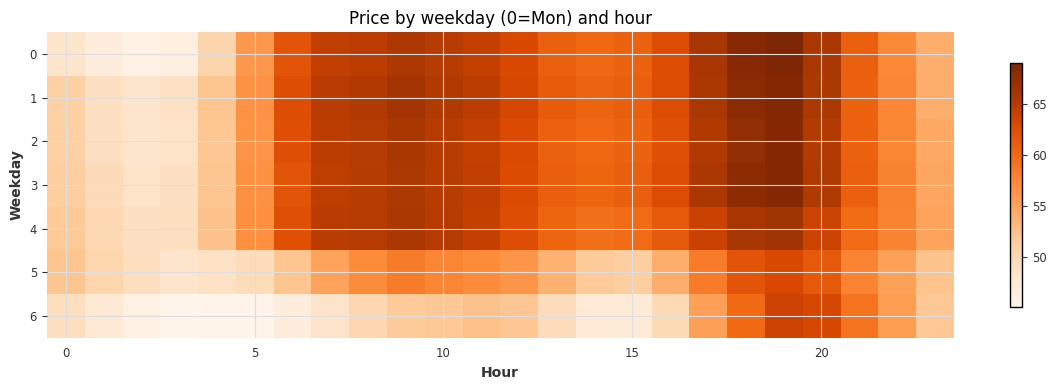

In [27]:
# Weekday–Hour Seasonality (Grouped by Hour)

gp = energy_data['total load actual'].groupby([energy_data.index.dayofweek,energy_data.index.hour]).mean().unstack()
fig, ax = plt.subplots(figsize=(12, 4))
im = ax.imshow(gp, aspect='auto', cmap='Blues')
ax.set_title('Load by weekday (0=Mon) and hour')
ax.set_xlabel('Hour')
ax.set_ylabel('Weekday')
fig.colorbar(im, ax=ax, shrink=0.8)
fig.tight_layout()
plt.show()


# Price: Weekday–Hour Seasonality (Grouped by Hour)

gp = energy_data['price actual'].groupby([energy_data.index.dayofweek,
                                               energy_data.index.hour]).mean().unstack()
fig, ax = plt.subplots(figsize=(12, 4))
im = ax.imshow(gp, aspect='auto', cmap='Oranges')
ax.set_title('Price by weekday (0=Mon) and hour')
ax.set_xlabel('Hour')
ax.set_ylabel('Weekday')
fig.colorbar(im, ax=ax, shrink=0.8)
fig.tight_layout()
plt.show()



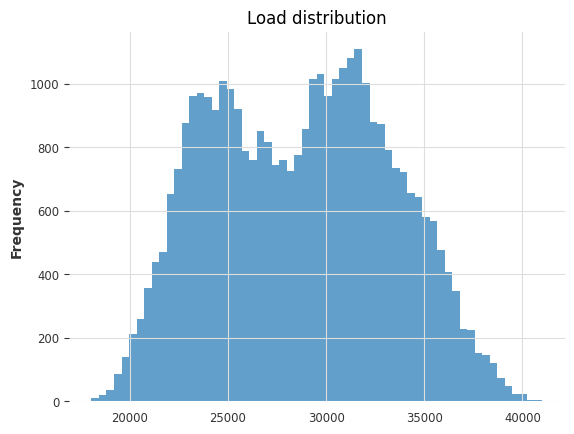

In [28]:
# load distribution
yL = energy_data["total load actual"]
yL.plot(kind="hist", bins=60, alpha=.7, title="Load distribution", color='tab:blue')
plt.show()

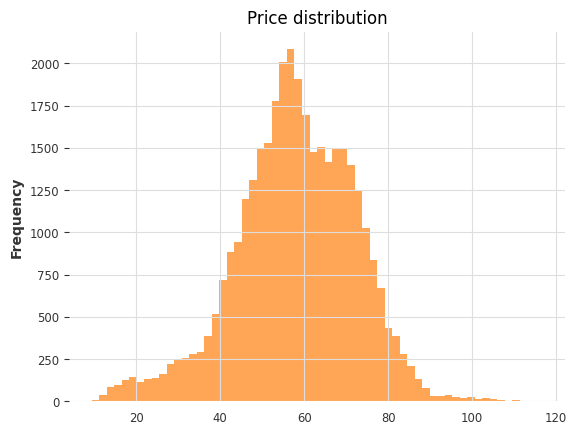

Price < 0 ratio: 0.0


In [29]:
# price distribution
yP = energy_data["price actual"]
yP.plot(kind="hist", bins=60, alpha=.7, title="Price distribution", color='tab:orange')
plt.show()
print("Price < 0 ratio:", (yP<0).mean())


~normarlization distribution, no need log1p transformation. No big difference between using mae and mse based on this distribution.

In [30]:
def plot_acf_clean(s, max_lag=200, title="", highlight=(), daily=False,
                   color='tab:blue', highlight_color='k'):
    s = s.dropna()
    if daily:
        s = s.resample("D").mean()

    fig, ax = plt.subplots(figsize=(12, 4))

    plot_acf(
        s, lags=max_lag, ax=ax, zero=False, alpha=0.05,
        vlines_kwargs={'colors': color, 'linewidth': 1.2, 'alpha': 0.95},
        marker='o'
    )

    ax.set_title(title)
    ax.set_xlim(0, max_lag)
    ax.set_ylim(-1.0, 1.0)
    ax.grid(True, alpha=0.3)

    for k in highlight:
        if k <= max_lag:
            ax.axvline(k, color=highlight_color, linestyle="--", linewidth=0.8, alpha=0.7)
            ax.text(k+1, 0.88, str(k), fontsize=9, alpha=0.7, color=highlight_color)

    plt.tight_layout()
    plt.show()

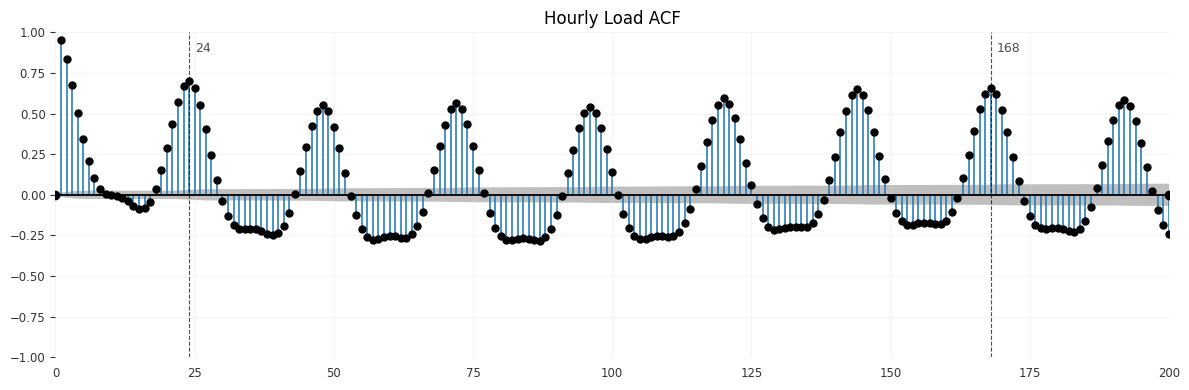

In [31]:
# Load: ACF (Hourly)
plot_acf_clean(energy_data['total load actual'], max_lag=200,
               title='Hourly Load ACF', color='tab:blue', highlight=(24, 168))

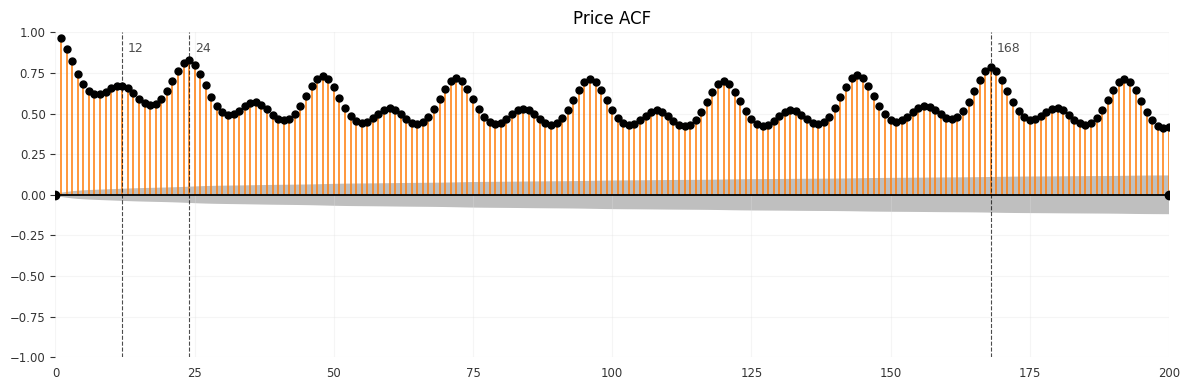

In [32]:
# Price: ACF (Hourly)
plot_acf_clean(energy_data['price actual'], max_lag=200,
               title='Price ACF', color='tab:orange', highlight=(12, 24, 168))

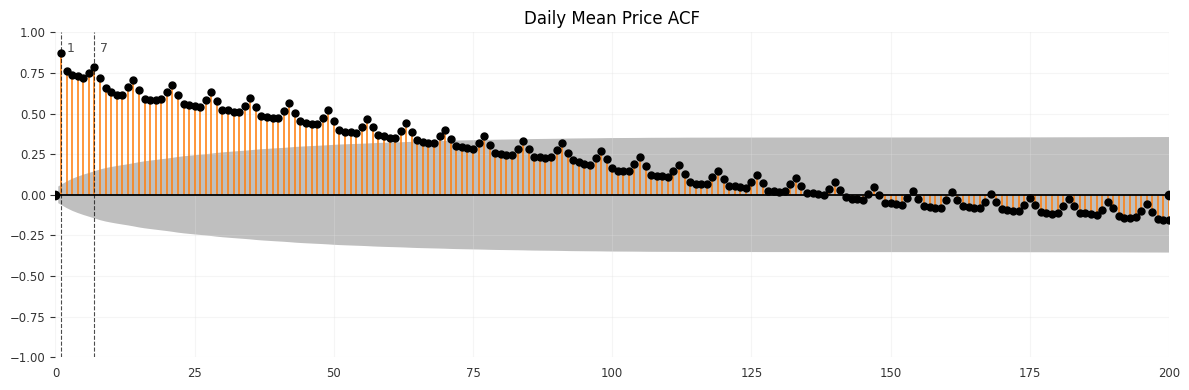

In [33]:
# Price: ACF (daily mean)
plot_acf_clean(energy_data['price actual'], max_lag=200,
               title='Daily Mean Price ACF', color='tab:orange', highlight=(1, 7, ), daily=True)

Findings:
- Daily seasonality
- Weeklly seasonality
- Persistence

actions: 
- Trees: 
    - lags=[1, 2, 3, 6, 12, 24, 25, 48, 168] relative to the last known time t
    - rolling w = [24, 168]
    - diff = [1, 24, 168]
- NN: 
    - Encoder Length >= 168
    - rolling w = [24, 168]
    - diff = [1, 24, 168]

In [ ]:
gen_cols = [c for c in energy_data.columns if c.startswith('generation ') and 'pumped storage consumption' not in c] 

# # Daily mean to reduce visual noise 
gen_daily = energy_data[gen_cols].resample('D').mean() 
gen_smooth = gen_daily.rolling(window=7, min_periods=1).mean()

order = gen_smooth.mean().sort_values(ascending=False).index
labels = [c.replace('generation ', '') for c in order]

base = list(plt.colormaps['tab20'].colors)
idx = list(range(0,20,2)) + list(range(1,20,2)) 
colors = [base[idx[i % 20]] for i in range(len(order))]


fig, ax = plt.subplots(figsize=(12,5))
ax.stackplot(gen_smooth.index, gen_smooth[order].T.values,
             labels=labels, colors=colors, linewidth=0)
ax.set_title('Generation Mix (7-day Mean)')
ax.set_ylabel('MW'); ax.grid(True, alpha=0.3)
ax.legend(ncols=1, fontsize=8, loc='center left', bbox_to_anchor=(1.01, 0.5))
plt.tight_layout(); plt.show()


In [ ]:
# Generation by Source (30-day Mean): Small Multiples

# 1) Prepare series: daily mean + 30-day rolling mean; order by long-run average
gen_cols = [c for c in energy_data.columns
            if c.startswith('generation ') and 'pumped storage consumption' not in c]
gen_daily  = energy_data[gen_cols].resample('D').mean()
gen_roll30 = gen_daily.rolling(30, min_periods=1).mean()
order = gen_roll30.mean().sort_values(ascending=False).index
titles = [c.replace('generation ', '') for c in order]

# 2) Small multiples: share the same X axis across plots, keep independent Y axes
n = len(order); ncols = 1
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 2*nrows), sharex=True)  # sharex=True !
axes = axes.ravel()

xmin, xmax = gen_roll30.index.min(), gen_roll30.index.max()
locator = mdates.YearLocator()       
fmt     = mdates.DateFormatter('%Y-%m')

for i, col in enumerate(order):
    ax = axes[i]
    ax.plot(gen_roll30.index, gen_roll30[col], linewidth=1.0)
    ax.set_title(titles[i], fontsize=9)
    ax.set_xlim(xmin, xmax)          
    ax.grid(True, alpha=0.25)
    if i % ncols == 0:
        ax.set_ylabel('MW')          
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(fmt)

# 3) Hide X labels on inner plots; show them only on the bottom row
for ax in axes:
    ax.label_outer()

# Turn off any unused subplots (when grid has extra slots)
for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle('Generation by source (30-day mean)', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()


**Findings**

- Seasonality: Strong annual cycle and clear weekday–hour pattern in load; solar peaks in summer, near-zero in winter.

- Load–Price relation: Co-movement is visible, but price is much more volatile with occasional spikes.

- Renewables: Onshore wind changes a lot from week to week. Solar is smaller overall but very seasonal.

- Fossil Gas/coal： average level can shift for several weeks or months.

- Hydro: Reservoir and run-of-river plants smooth peaks and valleys and show clear seasons.


#### 1.3.2 weather data visualization

In [ ]:
def ez_box(df, x, y, title=None, percent=False, figsize=(12,4), rotation=12, palette='Set2'):
    """Simple, clean boxplot with outliers kept"""
    sns.set_theme(style="whitegrid", context="notebook")
    flierprops = dict(marker='o', markersize=2, markerfacecolor='none',
                      markeredgecolor='0.3', alpha=0.5)
    fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
    sns.boxplot(data=df, x=x, y=y,
                showfliers=True, fliersize=2, flierprops=flierprops,
                palette=palette, width=0.6, linewidth=1.2, ax=ax)
    ax.set(title=title or f'{y} by {x}', xlabel=x, ylabel=y)
    if rotation: ax.tick_params(axis='x', labelrotation=rotation)
    if percent:  ax.set_ylim(-5, 105)
    ax.grid(True, axis='y', alpha=0.25)
    return ax


In [ ]:
# Temperature
ez_box(weather_data, 'city_name', 'temp', 'Temperature by City')

In [ ]:
# plot daily mean temperature curve for 5 cities
fig, ax = plt.subplots(figsize=(12,4))
for i, city in enumerate(weather_data['city_name'].unique()):
    city_temp = weather_data[weather_data['city_name'] == city]['temp'].sort_index().resample('D').mean()
    ax.plot(city_temp[-365:].index, city_temp[-365:].values, label=city, color=plt.cm.tab10(i))
ax.set_title('Daily Mean Temperature Curve for 5 Cities')
ax.set_ylabel('Temperature (K)')
ax.legend()
plt.tight_layout()
plt.show()


Findings: tempereture envolves similar across different cities

In [ ]:
# Pressure
ez_box(weather_data, 'city_name', 'pressure', 'Pressure Distribution by City')

In [ ]:
# pressure daily mean curve for 5 cities
fig, ax = plt.subplots(figsize=(12,4))
for i, city in enumerate(weather_data['city_name'].unique()):
    city_pressure = weather_data[weather_data['city_name'] == city]['pressure'].sort_index().resample('D').mean()
    ax.plot(city_pressure[-365:].index, city_pressure[-365:].values, label=city, color=plt.cm.tab10(i))
ax.set_title('Daily Mean Pressure Curve for 5 Cities')
ax.set_ylabel('Pressure (hPa)')
ax.legend()
plt.tight_layout()
plt.show()

Findings: 
- Pressure envoles similar across different cities.
- Outliers: the pressure unit might be wrong

In [ ]:
# visualization of wind speed data
ez_box(weather_data, 'city_name', 'wind_speed', 'Wind Speed Distribution by City')

In [ ]:
# wind speed daily mean curve for 5 cities
fig, ax = plt.subplots(figsize=(12,4))
for i, city in enumerate(weather_data['city_name'].unique()):    
    city_wind = weather_data[weather_data['city_name'] == city]['wind_speed'].sort_index().resample('D').mean()
    ax.plot(city_wind[-365:].index, city_wind[-365:].values, label=city, color=plt.cm.tab10(i))
ax.set_title('Daily Mean Wind Speed Curve for 5 Cities')
ax.set_ylabel('Wind Speed (m/s)')
ax.legend()
plt.tight_layout()
plt.show()

Findings:
- wind speed envolves differently between different cities
- Outliers: high speed

In [ ]:
# humidity
ez_box(weather_data, 'city_name', 'humidity', 'Humidity Distribution by City')

In [ ]:
# humidity daily mean curve for 5 cities
fig, ax = plt.subplots(figsize=(12,4))
for i, city in enumerate(weather_data['city_name'].unique()):
    city_humidity = weather_data[weather_data['city_name'] == city]['humidity'].sort_index().resample('D').mean()
    ax.plot(city_humidity[-365:].index, city_humidity[-365:].values, label=city, color=plt.cm.tab10(i))
ax.set_title('Daily Mean Humidity Curve for 5 Cities')
ax.set_ylabel('Humidity (%)')
ax.legend()
plt.tight_layout()
plt.show()

Findings:
- Humidity envolves differently between different cities

In [ ]:
# Clouds_all
ez_box(weather_data, 'city_name', 'clouds_all', 'Cloudiness Distribution by City', percent=True)

In [ ]:
# clouds_all daily mean curve for 5 cities
fig, ax = plt.subplots(figsize=(12,4))
for i, city in enumerate(weather_data['city_name'].unique()):
    city_clouds = weather_data[weather_data['city_name'] == city]['clouds_all'].sort_index().resample('D').mean()
    ax.plot(city_clouds[-365:].index, city_clouds[-365:].values, label=city, color=plt.cm.tab10(i))
ax.set_title('Daily Mean Cloudiness Curve for 5 Cities')
ax.set_ylabel('Cloudiness (%)')
ax.legend()
plt.tight_layout()
plt.show()

Findings:

- Cloudiness shows a heavy zero mass and a long right tail in several cities.
- Cloudiness envolves differently among different cities

In [ ]:
# visualization of rain_1h data
ez_box(weather_data, 'city_name', 'rain_1h', 'Rain (1h) Distribution by City')

In [ ]:
# rain_1h daily mean curve for 5 cities
fig, ax = plt.subplots(figsize=(12,4))
for i, city in enumerate(weather_data['city_name'].unique()):
    city_rain = weather_data[weather_data['city_name'] == city]['rain_1h'].sort_index().resample('D').mean()
    ax.plot(city_rain[-365:].index, city_rain[-365:].values, label=city, color=plt.cm.tab10(i))
ax.set_title('Daily Mean Rain (1h) Curve for 5 Cities')
ax.set_ylabel('Rain (mm)')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
weather_data["rain_1h"].describe()

In [ ]:
# ---- Zero Rain/Snow Analysis ----
def zero_ratio(s):
    return (s==0).mean()


zr = weather_data.groupby('city_name').agg(
    rain1_zero_rate=('rain_1h', zero_ratio),
    rain3_zero_rate=('rain_3h', zero_ratio),
    snow3_zero_rate=('snow_3h', zero_ratio),
).sort_values(['rain1_zero_rate', 'rain3_zero_rate', 'snow3_zero_rate'], ascending=False)

fig, ax = plt.subplots(figsize=(11,4), constrained_layout=True)
zr.plot(kind='bar', ax=ax, colormap='Set2', width=0.9)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), frameon=False, borderaxespad=0)
ax.tick_params(axis='x', labelrotation=0)
plt.show()


Findings:
- It doesn't rain or snow on most days across all 5 cities

### 1.4 Summary

**Key Findings**

- Load has highly autocorrelation with lag 1, 2, 3, 12, 24, 48, 168

- Daily price has highly autocorrelation with lag 1, 2, 3, 12, 24, 48, 168

- Seasonality: Strong annual cycle and clear weekday–hour pattern in load; solar peaks in summer, near-zero in winter.

- Load–Price relation: Co-movement is visible, but price is much more volatile with occasional spikes.

- Renewables: Onshore wind changes a lot from week to week. Solar is smaller overall but very seasonal.

- Fossil Gas/coal： average level can shift for several weeks or months.

- Hydro: Reservoir and run-of-river plants smooth peaks and valleys and show clear seasons.

- It doesn't rain or snow on most days

- temperature and pressure evolve in a similar trend for 5 cities

- wind speed, humunity, clouds_all have different pattern among different cities


**Action Plan**
- clean weather data: rolling clipping temp, pressure, wind_speed, huminity
- pivot weather data to wide format by expanding city_name
- temperature: use temp_mean, temp_min, temp_max, temp_range
- pressure: use pressure_mean
- wind_speed: use mean, max
- humidity: use mean
- clouds_all: use mean, heavy_frac among all cities, if_heavy
- rain_1h: use rain_any, rain_mean, rain_sum, rain_sum24
- merge energy and weather data
- parse datetime and add time features: hour, day of week, is_weekend, month, season, sin/cos, holidays
- Define baseline: take load and price values of previous day at the same time: lag 24
- split trian, validation, and test(time-based split)
- load lags: besides lag 24, add lag 1,2,3,24,48
- load rolling features: rolling mean (and maybe std) over 3, 12, 24, 168 hours, computed using only past data (no leakage).
- price lags: besides lag 24, add lag 1,2,3,12,24,48.
- price rolling features: rolling mean (±std) over 3, 12, 24, 168 hours, using only history.
- diff(3, 12, 24, 168)
- one fold first before applying CV on models xgboost and lstm
- point forecasting + probability forecasting
- hybrid models(xgboost, lstm, tft)

## 2. Data Preprocessing

### 2.1 weather data preprocessing

In [ ]:
def roll_clip_mad(
    df: pd.DataFrame,
    col: str,
    group: str = "city_name",
    w: int = 45*24,          # window in hours (e.g., 45 days for temperature)
    k: float = 5.0,          # robustness factor (larger = more conservative)
    n_min: int = 24,         # minimum past samples required to enable clipping
    lower_phys: float | None = None,   # optional physical lower bound
    upper_phys: float | None = None,   # optional physical upper bound
) -> pd.DataFrame:

    out = df.copy().sort_values([group, df.index.name])
    x = out[col].astype(float)

    # rolling median and MAD per city
    med = x.groupby(out[group]).transform(lambda s: s.rolling(w, min_periods=n_min).median()) # We perform a groupby using an explicit grouping Series (a Series-based grouper) rather than referring to a column name directly.
    mad = (x - med).abs().groupby(out[group]).transform(
            lambda s: s.rolling(w, min_periods=n_min).median())
    sigma = (1.4826 * mad).clip(lower=1e-6)  # avoid zero-width bands

    # enable clipping only when we have enough past data
    cnt = x.groupby(out[group]).transform(lambda s: s.rolling(w, min_periods=n_min).count())

    lo = med - k * sigma
    hi = med + k * sigma

    x_clip = x.where(cnt < n_min, x.clip(lower=lo, upper=hi))

    # optional physical bounds
    if lower_phys is not None:
        x_clip = x_clip.clip(lower=lower_phys)
    if upper_phys is not None:
        x_clip = x_clip.clip(upper=upper_phys)

    out[col + "_clip"] = x_clip
    return out

# Temperature (Kelvin): conservative bands for all cities
wd = roll_clip_mad(weather_data, col="temp", w=45*24, k=5, n_min=24*7, lower_phys=250, upper_phys=325)

# Pressure (after unit fix), shorter window
wd["pressure"] = np.where(wd["pressure"] > 2000, wd["pressure"]/1000, wd["pressure"])
wd = roll_clip_mad(wd, col="pressure", w=21*24, k=5, n_min=24*7, lower_phys=870, upper_phys=1100)

# wind speed
wd = roll_clip_mad(wd, col="wind_speed", w=30*24, k=5, n_min=24*7, lower_phys=0, upper_phys=60)

# humidity
wd = roll_clip_mad(wd, col="humidity", w=21*24, k=5, n_min=24*7, lower_phys=0, upper_phys=100)

In [ ]:
wd.columns

In [ ]:
keep_wcols = ["city_name",
              "temp_clip",
              "pressure_clip",
              "wind_speed_clip",
              "humidity_clip",
              "clouds_all",
              "rain_1h",
              ] # for the sake of simplicity, only keep these weather columns

cwd = wd[keep_wcols]

In [ ]:
cwd.head() # we will upper clip rain_1h after splitting training and test sets

In [ ]:
# visualization again after clipping
# 1) Temperature
ez_box(cwd, 'city_name', 'temp_clip', 'Clipped Temperature by City')

In [ ]:
# Pressure
ez_box(cwd, 'city_name', 'pressure_clip', 'Clipped Pressure by City')

In [ ]:
# wind speed
ez_box(cwd, 'city_name', 'wind_speed_clip', 'Clipped Wind Speed by City')

In [ ]:
# humidity_clip
ez_box(cwd, 'city_name', 'humidity_clip', 'Clipped Humidity by City')

In [ ]:
# pivot to wide format

vars_to_expand = ['temp_clip', 'pressure_clip', 'wind_speed_clip', 'humidity_clip', "clouds_all", "rain_1h"]
wide = cwd.pivot_table(index="time", columns="city_name", values=vars_to_expand, aggfunc="first")

new_cols = []
for col in wide.columns:
    var, city = col
    var = var.strip()
    city = city.strip()
    new_cols.append(f"{var}_city_{city}")
wide.columns = new_cols

wide_weather = wide.sort_index(axis=1)

In [ ]:
# reduce temperature dimension, I know, 5 to 5.

temp_cols = [c for c in wide_weather.columns if c.startswith('temp_clip_city_')]
wide_weather["temp_mean"] = wide_weather[temp_cols].mean(axis=1)
wide_weather["temp_min"] = wide_weather[temp_cols].min(axis=1)
wide_weather["temp_max"] = wide_weather[temp_cols].max(axis=1)
wide_weather["temp_range"] = wide_weather["temp_max"] - wide_weather["temp_min"]
wide_weather["temp_rolling_mean_24"] = wide_weather["temp_mean"].rolling(window=24, min_periods=1).mean()

# reduce pressure dimension

pres_cols = [c for c in wide_weather.columns if c.startswith('pressure_clip_city_')]
wide_weather["pressure_mean"] = wide_weather[pres_cols].mean(axis=1)

# reduce wind speed dimension
wind_cols = [c for c in wide_weather.columns if c.startswith('wind_speed_clip_city_')]
wide_weather["wind_speed_mean"] = wide_weather[wind_cols].mean(axis=1)
wide_weather["wind_speed_max"] = wide_weather[wind_cols].max(axis=1)

# reduce humidity dimension
humidity_cols = [c for c in wide_weather.columns if c.startswith('humidity_clip_city_')]
wide_weather["humidity_mean"] = wide_weather[humidity_cols].mean(axis=1)

# reduce clouds_all dimension
cloud_tau = 60 # threshold for heavy clouds

cloud_cols = [c for c in wide_weather.columns if c.startswith('clouds_all_city_')]
wide_weather["clouds_all_mean"] = wide_weather[cloud_cols].mean(axis=1)
wide_weather["clouds_heavy_frac"] = wide_weather[cloud_cols].gt(cloud_tau).sum(axis=1) / len(cloud_cols)

# reduce rain_1h dimension
rain_cols = [c for c in wide_weather.columns if c.startswith('rain_1h_city_')]
wide_weather["rain_1h_mean"] = wide_weather[rain_cols].mean(axis=1)
wide_weather["rain_1h_any"] = wide_weather[rain_cols].gt(0).any(axis=1).astype(int)
wide_weather["rain_sum24"] = wide_weather[rain_cols].sum(axis=1).rolling(window=24, min_periods=1).sum()

wide_weather.drop(columns=temp_cols + pres_cols + humidity_cols + wind_cols + cloud_cols + rain_cols, inplace=True)

In [ ]:
wide_weather.info()

In [ ]:
wide_weather.describe()

### 2.2 Data merging

In [ ]:
# merge energy_data and wide_weather on time index
energy_data = energy_data.sort_index()
wide_weather = wide_weather.sort_index()
df = energy_data.join(wide_weather, how="left", rsuffix="_wx").sort_index()

df.index = df.index.tz_localize(None)

In [ ]:
# Check time continuity
time_diff = df.index.to_series().diff().dropna()
missing_intervals = time_diff[time_diff != pd.Timedelta(hours=1)]
print(f"Number of missing time intervals after merge: {len(missing_intervals)}")

In [ ]:
# check duplicate entries
duplicate_entries = df[df.duplicated()]
print(f"Number of duplicate entries: {len(duplicate_entries)}")

### 2.3 Time Features Engineering

In [ ]:
# add time features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month

# add is_weekend feature
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)


years = pd.Index(df.index.year).unique().tolist()
spain_holidays = holidays.country_holidays("ES", years=years)
dates = pd.Series(df.index.date, index=df.index)
df["is_holiday"] = dates.isin(spain_holidays).astype("int8")

In [ ]:
# cyclic time features
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df.drop(columns=["hour", "dayofweek", "month"], inplace=True)

### 2.4 General Feature Engineering

In [ ]:
# although darts xgboost and lstm can get lagged features internally, we still create lagged features explicitly as fixed future vol when using xgboost or as high-quality features when using lstm
seasonal_lags = [24, 25, 48, 168]
seasonal_lag_cols = []
for lag in seasonal_lags:
    price_lag_col = f"price_actual_lag_{lag}"
    seasonal_lag_cols.append(price_lag_col)
    load_lag_col = f"total_load_actual_lag_{lag}"
    seasonal_lag_cols.append(load_lag_col)
    df[price_lag_col] = df['price actual'].shift(lag)
    df[load_lag_col] = df['total load actual'].shift(lag)

In [ ]:
# capture targets' characteristics on different frequency patterns.
rws= [3, 6, 12, 24, 168] 
for rw in rws:
    df[f'total_load_actual_rw_{rw}_mean'] = df['total load actual'].rolling(window=rw, min_periods=rw).mean()
    df[f'price_actual_rw_{rw}_mean'] = df['price actual'].rolling(window=rw, min_periods=rw).mean()
    df[f'total_load_actual_rw_{rw}_std'] = df['total load actual'].rolling(window=rw, min_periods=rw).std()
    df[f'price_actual_rw_{rw}_std'] = df['price actual'].rolling(window=rw, min_periods=rw).std()

# 
diffs = [3, 12, 24, 168] 
for diff in diffs:
    df[f'total_load_actual_diff_{diff}'] = df["total load actual"].diff(periods=diff)
    df[f'price_actual_diff_{diff}'] = df["price actual"].diff(periods=diff)

df.dropna(inplace=True)

In [ ]:
eps = 1e-6
gen_cols = [
    'generation biomass',
    'generation fossil brown coal/lignite',
    'generation fossil gas',
    'generation fossil hard coal',
    'generation fossil oil',
    'generation hydro run-of-river and poundage',
    'generation hydro water reservoir',
    'generation nuclear',
    'generation other',
    'generation other renewable',
    'generation solar',
    'generation waste',
    'generation wind onshore',
]
denom = df[gen_cols].astype(float).fillna(0.0).sum(axis=1)
denom = denom.replace([np.inf, -np.inf], 0.0)
denom = denom.where(denom > 0, eps) 

wind   = df['generation wind onshore'].astype(float).fillna(0.0)
solar  = df['generation solar'].astype(float).fillna(0.0)
hydro  = (
    df['generation hydro run-of-river and poundage'].astype(float).fillna(0.0) +
    df['generation hydro water reservoir'].astype(float).fillna(0.0)
)
fossil = (
    df['generation fossil gas'].astype(float).fillna(0.0) +
    df['generation fossil hard coal'].astype(float).fillna(0.0) +
    df['generation fossil brown coal/lignite'].astype(float).fillna(0.0) +
    df['generation fossil oil'].astype(float).fillna(0.0)
)
other_ren = (
    df['generation biomass'].astype(float).fillna(0.0) +
    df['generation other renewable'].astype(float).fillna(0.0)
)
nuclear = df['generation nuclear'].astype(float).fillna(0.0)

# 占比（clip 到 [0,1]）
df['share_wind']      = (wind   / denom).clip(0, 1)
df['share_solar']     = (solar  / denom).clip(0, 1)
df['share_hydro']     = (hydro  / denom).clip(0, 1)
df['share_fossil']    = (fossil / denom).clip(0, 1)
df['share_other_ren'] = (other_ren / denom).clip(0, 1)
df['share_nuclear']   = (nuclear / denom).clip(0, 1)


In [ ]:
# For blocked lstm only
known_cols = [ 
 'temp_mean',
 'temp_min',
 'temp_max',
 'temp_range',
 'temp_rolling_mean_24',
 'pressure_mean',
 'wind_speed_mean',
 'wind_speed_max',
 'humidity_mean',
 'clouds_all_mean',
 'clouds_heavy_frac',
 'rain_1h_mean',
 'rain_1h_any',
 'rain_sum24',
 'is_weekend',
 'is_holiday',
 'hour_sin',
 'hour_cos',
 'dayofweek_sin',
 'dayofweek_cos',
 'month_sin',
 'month_cos',
]

lstm_shifted_known_cols = []
for col in known_cols:
    shifted_known_col = col + "_shifted"
    lstm_shifted_known_cols.append(shifted_known_col)
    df[shifted_known_col] = df[col].shift(-2*H)

In [ ]:
df.dropna(inplace=True)

### 2.6 Train/Validation/Test Split

In [ ]:
# cast all columns to float32
df = df.astype(np.float32)
days = df.index.normalize().unique()
n_days = len(days)
print(f"Total days in dataset: {n_days}")

In [ ]:
# split train, test sets
days = days.sort_values()
test_days = days[-31:-1] # exclude the very last day to avoid potential issues with future features
trainval_days = days[:-31]

is_test = df.index.normalize().isin(test_days)
trainval_df = df[~is_test].copy()
test_df = df[is_test].copy()

In [ ]:
# For simplicity, we use only 1 fold here. For a robust evaluation, we'll use rolling cross-validation later.

# Fold = 0
train_days = trainval_days[1:-31] # exclude the very first day to avoid potential issues with lag features
val_days = trainval_days[-31:]

# create boolean masks
is_train = trainval_df.index.normalize().isin(train_days)
is_val = trainval_df.index.normalize().isin(val_days)

train_df = trainval_df[is_train].copy()
val_df   = trainval_df[is_val].copy()

## 3. Trainning

### 3.1 Baseline Model

In [ ]:
y_tr_base = TimeSeries.from_dataframe(train_df, value_cols=target_cols)
y_val_base   = TimeSeries.from_dataframe(val_df, value_cols=target_cols)
y_te_base  = TimeSeries.from_dataframe(test_df, value_cols=target_cols)

# identify the start and end times of each set, adjusted for forecast issue hour
val_start = y_val_base.start_time() + pd.Timedelta(hours=ISSUE_HOUR)
val_end = y_val_base.end_time() - pd.Timedelta(hours=ISSUE_HOUR)
print("Validation set starts at:", val_start)
print("Validation set ends at:", val_end)

test_start = y_te_base.start_time() + pd.Timedelta(hours=ISSUE_HOUR)
test_end = y_te_base.end_time() - pd.Timedelta(hours=ISSUE_HOUR)
print("Test set starts at:", test_start)
print("Test set ends at:", test_end)

In [ ]:
# Naive Baseline Model Forecasting and Evaluation

y_price_val_pred_b = y_tr_base.append(y_val_base).shift(H).slice(val_start, val_end)
y_price_val_actual = y_val_base.slice(val_start, val_end)
# mae, rmse
mae_val_baseline = mae(y_price_val_actual, y_price_val_pred_b)
rmse_bal_baseline = rmse(y_price_val_actual, y_price_val_pred_b)

y_price_test_pred_b = y_val_base.append(y_te_base).shift(H).slice(test_start, test_end)
y_price_test_actual = y_te_base.slice(test_start, test_end)
# mae, rmse
mae_te_baseline = mae(y_price_test_actual, y_price_test_pred_b)
rmse_te_baseline = rmse(y_price_test_actual, y_price_test_pred_b)


print(f"Validation Set Baseline - MAE: {mae_val_baseline:.4f}, RMSE: {rmse_bal_baseline:.4f}")
print(f"Test Set Baseline - MAE: {mae_te_baseline:.4f}, RMSE: {rmse_te_baseline:.4f}")

In [ ]:
# plot
plt.figure(figsize=(12,4))
y_price_test_actual[-24*7:].plot(label='True Values', color='tab:orange')
y_price_test_pred_b[-24*7:].plot(label='Baseline Prediction', color='tab:blue', linestyle='--')
plt.legend()
plt.title('Baseline Prediction vs True Values on Test Set')
plt.xlabel('Time')
plt.ylabel('Price actual (EUR/MWh)')

### 3.2 XGBoost

In [ ]:
future_cols = known_cols + seasonal_lag_cols
past_cols = [c for c in df.columns.tolist() if c not in ['price actual'] + future_cols + lstm_shifted_known_cols] # exclue shifted known cols used only for blocked lstm
print(f"future_cols: {future_cols}")
print(f"past_cols: {past_cols}")

In [ ]:
# generate darts TimeSeries datasets
def mk_ts_block(d, target_cols=target_cols, past_cols=past_cols, future_cols=future_cols):
    y   = TimeSeries.from_dataframe(d, value_cols=target_cols)
    pst = TimeSeries.from_dataframe(d[past_cols])
    if future_cols:
        fut = TimeSeries.from_dataframe(d, value_cols=future_cols)
        return y, pst, fut
    else:
        return y, pst

y_tr_xgb,  past_tr_xgb, fut_tr_xgb  = mk_ts_block(train_df, target_cols=target_cols, past_cols=past_cols, future_cols=future_cols)
y_val_xgb, past_val_xgb, fut_val_xgb  = mk_ts_block(val_df,  target_cols=target_cols, past_cols=past_cols, future_cols=future_cols)
y_te_xgb,  past_te_xgb, fut_te_xgb  = mk_ts_block(test_df,  target_cols=target_cols, past_cols=past_cols, future_cols=future_cols)

In [ ]:
ctx_y_xgb = y_tr_xgb.append(y_val_xgb)
ctx_p_xgb = past_tr_xgb.append(past_val_xgb)
ctx_f_xgb = fut_tr_xgb.append(fut_val_xgb)

def align_start(ts, t0, hour):
    for t in ts.time_index:
        if t >= t0 and t.hour == hour:
            return t
    return t0


lags_target = [-1, -2, -3, -12, -24, -48, -168]                    
lags_past   = [-1, -2, -3, -12, -24, -48, -168]                     
lags_fut = {
    "default_lags": list(range(0, 2 * H)),
    **{col: list(range(0, H)) for col in seasonal_lag_cols}
}

In [ ]:
# We use a subset of the context data for hyperparameter optimization to speed up the process.
SUB_LEN = 24*365*2  # last 2 years

ctx_y_sub = ctx_y_xgb[-SUB_LEN:]
ctx_p_sub = ctx_p_xgb[-SUB_LEN:]
ctx_f_sub = ctx_f_xgb[-SUB_LEN:]


y_tr_sub   = ctx_y_sub[:-H*40]   
y_val_sub  = ctx_y_sub[-H*40:]
past_tr_sub= ctx_p_sub[:-H*40]
past_val_sub=ctx_p_sub[-H*40:]
fut_tr_sub = ctx_f_sub[:-H*40]
fut_val_sub= ctx_f_sub[-H*40:]

min_delta = 1e-4

def build_xgb_model(trial):
    # ------- fine-tune hyperparameters -------
    learning_rate   = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    max_depth       = trial.suggest_int("max_depth", 3, 8)
    min_child_weight= trial.suggest_float("min_child_weight", 1.0, 10.0)
    subsample       = trial.suggest_float("subsample", 0.6, 1.0)
    colsample_bt    = trial.suggest_float("colsample_bytree", 0.6, 1.0)
    reg_lambda      = trial.suggest_float("reg_lambda", 1e-2, 10.0, log=True)
    reg_alpha       = trial.suggest_float("reg_alpha", 1e-3, 1.0, log=True)
    gamma           = trial.suggest_float("gamma", 0.0, 5.0)

    # ------- Darts XGBModel -------
    xgb_model = XGBModel(
        # Darts params
        lags=lags_target,
        lags_past_covariates=lags_past,
        lags_future_covariates=lags_fut,
        output_chunk_length=H,
        multi_models=True, 

        # To XGBRegressor
        objective="reg:squarederror",
        n_estimators=300,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bt,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        gamma=gamma,
        tree_method="hist",
        device="cuda",          
        random_state=42,
        eval_metric="rmse",

        callbacks=[
            xgb.callback.EarlyStopping(
                rounds=30,
                min_delta=min_delta,
                save_best=True
            )
        ],
    )

    return xgb_model

def objective(trial):


    xgb_model = build_xgb_model(trial)

    try:

        xgb_model.fit(
            series=y_tr_sub,
            past_covariates=past_tr_sub,
            future_covariates=fut_tr_sub,
            val_series=y_val_sub,
            val_past_covariates=past_val_sub,
            val_future_covariates=fut_val_sub,
            verbose=False,
        )
        best_iter = xgb_model.model.best_iteration
        trial.set_user_attr("best_iters_mean", best_iter)

        score = xgb_model.backtest(
            series=ctx_y,
            past_covariates=ctx_p,
            future_covariates=ctx_f,
            start=val_start,           
            forecast_horizon=H,
            stride=H,
            metric=rmse,              
            reduction=np.mean,
            last_points_only=False,
            retrain=False,
            verbose=False,
        )
        return score

    finally:
        del xgb_model

sampler = optuna.samplers.TPESampler(
    seed=42,
    n_startup_trials=5,
    multivariate=True,
    group=True,
)

pruner = optuna.pruners.MedianPruner(
    n_startup_trials=20,    
    n_warmup_steps=5,       
    interval_steps=1,
)

storage = "sqlite:///optuna_xgb_price_v1.db"

study = optuna.create_study(
    direction="minimize",
    study_name="study_xgb_price_v1",
    storage=storage,
    load_if_exists=True,
    sampler=sampler,
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials=50,     
    timeout=None,
    n_jobs=1,
)

print("Best params:", study.best_trial.params)
print("Best RMSE:", study.best_value)


In [ ]:
# Plot optimization history
fig = ov.plot_parallel_coordinate(
    study,
)
fig.show()

In [ ]:
# Plot param importance to see which hyperparameters matter most
fig = ov.plot_param_importances(study) 
fig.show()

In [ ]:
# Plot optimization history to see how the study progressed over trials
fig = ov.plot_optimization_history(study)
fig.show()

In [ ]:
# Load the best trial's parameters from the study
storage = "sqlite:///optuna_xgb_price_v1.db"
study = optuna.load_study(
    study_name="study_xgb_price_v1",
    storage=storage,
)
xgb_best_params = study.best_trial.params
print("Best params:", xgb_best_params)

In [ ]:
# ------- Train XGBModel with the best hyperparameters on the full training data -------
xgb_tv_model = XGBModel(
    # Darts
    lags=lags_target,
    lags_past_covariates=lags_past,
    lags_future_covariates=lags_fut,
    output_chunk_length=H,
    multi_models=True, 

    # To XGBRegressor
    objective="reg:squarederror",
    n_estimators=1000,
    learning_rate=xgb_best_params['learning_rate'],
    max_depth=xgb_best_params['max_depth'],
    min_child_weight=xgb_best_params['min_child_weight'],
    subsample=xgb_best_params['subsample'],
    colsample_bytree=xgb_best_params['colsample_bytree'],
    reg_lambda=xgb_best_params['reg_lambda'],
    reg_alpha=xgb_best_params['reg_alpha'],
    gamma=xgb_best_params['gamma'],
    tree_method="hist",
    device="cuda",                  
    random_state=42,
    eval_metric="rmse",

    callbacks=[
        xgb.callback.EarlyStopping(
            rounds=50,
            min_delta=min_delta,
            save_best=True
        )
    ],
)

xgb_tv_model.fit(
    series=y_tr,
    past_covariates=past_tr,
    future_covariates=fut_tr,
    val_series=y_val,
    val_past_covariates=past_val,
    val_future_covariates=fut_val,
    verbose=True,
)

In [ ]:
pred_val_xgb = xgb_tv_model.historical_forecasts(
    series=y_tr_xgb.append(y_val_xgb),            # context + the period you want to evaluate
    past_covariates=past_tr_xgb.append(past_val_xgb),  # updated past covariates
    future_covariates=fut_tr_xgb.append(fut_val_xgb),  # updated future covariates
    start=y_val_xgb.start_time(),             # begin forecasting at the first val timestamp
    forecast_horizon=24,
    stride=24,                            # one forecast per day
    last_points_only=False,               # returns a full TimeSeries aligned to truth
    retrain=False,                        # fast evaluation; set True if you want refits
    verbose=False,
)

pred_val_xgb_flat = pred_val_xgb[0]
for b in pred_val_xgb[1:]:
    pred_val_xgb_flat = pred_val_xgb_flat.append(b)
pred_val_xgb_on = pred_val_xgb_flat.slice(val_start, val_end)

# mae
mae_val_xgb = mae(pred_val_xgb_on, y_price_val_actual)
rmse_val_xgb = rmse(pred_val_xgb_on, y_price_val_actual)
print(f"XGBoost MAE on val set: {mae_val_xgb:.4f}")
print(f"XGBoost RMSE on val set: {rmse_val_xgb:.4f}")


In [ ]:
print("Best iteration per sub-model:", xgb_tv_model.model.best_iteration)

In [ ]:
lagged_feature_names = xgb_tv_model._lagged_feature_names
n_feat = len(lagged_feature_names)

model = next(iter(xgb_tv_model.models.values())) if hasattr(xgb_tv_model, "models") and isinstance(xgb_tv_model.models, dict) else xgb_tv_model.model
booster = model.get_booster() if hasattr(model, "get_booster") else model.booster_
sc = booster.get_score(importance_type="gain") 

imp = np.zeros(n_feat, dtype=float)
for k, v in sc.items():
    imp[int(k[1:])] = v  

fe_im = pd.Series(imp, index=lagged_feature_names, name="gain").sort_values(ascending=False)

# move the index into a column called 'feature'
fe_im_df = fe_im.rename_axis("feature").reset_index()

In [ ]:
fe_im_df.head(100)

In [ ]:
fe_im_df.tail(100)

### 3.3 LSTM

In [ ]:
df.columns.tolist()

In [ ]:
drop_cols = [c for c in df.columns.tolist() if 'cloud' in c or 'rain' in c or 'hydro' in c or 'humidity' in c or 'temp' in c]

org_time_cols = ['is_weekend',
                 'is_holiday',
                 'hour_sin',
                 'hour_cos',
                 'dayofweek_sin',
                 'dayofweek_cos',
                 'month_sin',
                 'month_cos',
                 ]
rest_cols = [c for c in df.columns.tolist() if c not in drop_cols + org_time_cols ]

In [ ]:
keep_cols = [
    'generation biomass',
    'generation fossil brown coal/lignite',
    'generation fossil gas',
    'generation fossil hard coal',
    'generation fossil oil',
    'generation nuclear',
    'generation other',
    'generation other renewable',
    'generation solar',
    'generation waste',
    'generation wind onshore',
    'forecast solar day ahead',
    'forecast wind onshore day ahead',
    'total load actual',
    'price actual',
    'pressure_mean',
    'wind_speed_mean',
    'wind_speed_max',
    'price_actual_lag_24',
    'total_load_actual_lag_24',
    'price_actual_lag_25',
    'total_load_actual_lag_25',
    'price_actual_lag_48',
    'total_load_actual_lag_48',
    'price_actual_lag_168',
    'total_load_actual_lag_168',
    'total_load_actual_rw_3_mean',
    'price_actual_rw_3_mean',
    'total_load_actual_rw_3_std',
    'price_actual_rw_3_std',
    'total_load_actual_rw_6_mean',
    'price_actual_rw_6_mean',
    'total_load_actual_rw_6_std',
    'price_actual_rw_6_std',
    'total_load_actual_rw_12_mean',
    'price_actual_rw_12_mean',
    'total_load_actual_rw_12_std',
    'price_actual_rw_12_std',
    'total_load_actual_rw_24_mean',
    'price_actual_rw_24_mean',
    'total_load_actual_rw_24_std',
    'price_actual_rw_24_std',
    'total_load_actual_rw_168_mean',
    'price_actual_rw_168_mean',
    'total_load_actual_rw_168_std',
    'price_actual_rw_168_std',
    'total_load_actual_diff_3',
    'price_actual_diff_3',
    'total_load_actual_diff_12',
    'price_actual_diff_12',
    'total_load_actual_diff_24',
    'price_actual_diff_24',
    'total_load_actual_diff_168',
    'price_actual_diff_168',
    'share_wind',
    'share_solar',
    'share_fossil',
    'share_other_ren',
    'share_nuclear',
    'pressure_mean_shifted',
    'wind_speed_mean_shifted',
    'wind_speed_max_shifted',
    'is_weekend_shifted',
    'is_holiday_shifted',
    'hour_sin_shifted',
    'hour_cos_shifted',
    'dayofweek_sin_shifted',
    'dayofweek_cos_shifted',
    'month_sin_shifted',
    'month_cos_shifted'
]

In [ ]:
lstm_cols = [c for c in keep_cols if c not in ['price actual']]

In [ ]:
# from darts import TimeSeries
def mk_ts_block(d):
    y   = TimeSeries.from_dataframe(d, value_cols=target_cols)
    pst = TimeSeries.from_dataframe(d[lstm_cols])
    return y, pst

y_tr_lstm,  past_tr_lstm  = mk_ts_block(train_df)
y_val_lstm, past_val_lstm  = mk_ts_block(val_df)
y_te_lstm,  past_te_lstm  = mk_ts_block(test_df)


sc_y = Scaler(scaler=StandardScaler())
sc_p = Scaler(scaler=StandardScaler())

y_tr_lstm_s    = sc_y.fit_transform(y_tr_lstm)
past_tr_lstm_s = sc_p.fit_transform(past_tr_lstm)

y_val_lstm_s    = sc_y.transform(y_val_lstm)
past_val_lstm_s = sc_p.transform(past_val_lstm)

y_te_lstm_s     = sc_y.transform(y_te_lstm)
past_te_lstm_s  = sc_p.transform(past_te_lstm)

In [ ]:
dloader_kwargs = {"num_workers": 5, "pin_memory": True, "persistent_workers": True}

torch.set_float32_matmul_precision("high") 

ctx_y_lstm = y_tr_lstm_s.append(y_val_lstm_s)
ctx_p_lstm = past_tr_lstm_s.append(past_val_lstm_s)

In [ ]:
class OptunaPruningCallback(PyTorchLightningPruningCallback, pl.Callback):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)


def build_model(trial):
    W           = trial.suggest_categorical("W", [48, 168])                
    hidden_dim  = trial.suggest_int("hidden_dim", 64, 256, step=64)
    n_layers    = trial.suggest_int("n_layers", 1, 3)
    dropout     = trial.suggest_float("dropout", 0.1, 0.4, step=0.1)        
    batch_size  = trial.suggest_categorical("batch_size", [64, 128, 256, 512])   
    lr          = trial.suggest_float("lr", 1e-4, 3e-3, log=True)          
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
    grad_clip = trial.suggest_categorical("gradient_clip_val", [0.0, 0.1, 1.0])

    run_id = datetime.now().strftime("%Y%m%d-%H%M%S")
    model_name = (f"optuna_dprice_{trial.number}_{run_id}_W{W}_hd{hidden_dim}_L{n_layers}_do{dropout}_bs{batch_size}_lr{lr:g}_wd{weight_decay:g}")

    early_stop = EarlyStopping(monitor="val_loss", mode="min", min_delta=1e-4, patience=10)
    #lr_monitor = LearningRateMonitor(logging_interval="epoch")
    pl_pruning = OptunaPruningCallback(trial, monitor="val_loss")


    model = BlockRNNModel(
        model="LSTM",
        loss_fn=nn.SmoothL1Loss(beta=1.0),
        input_chunk_length=W,
        output_chunk_length=H,
        n_rnn_layers=n_layers,
        hidden_dim=hidden_dim,
        dropout=dropout,
        batch_size=batch_size,
        n_epochs=50,                                          
        optimizer_cls=torch.optim.AdamW,
        optimizer_kwargs={"lr": lr, "weight_decay": weight_decay},
        lr_scheduler_cls=torch.optim.lr_scheduler.CosineAnnealingLR,
        lr_scheduler_kwargs={"T_max": 40, "eta_min": 1e-5},   
        random_state=42,
        log_tensorboard=False,
        work_dir="./runs",
        model_name=model_name,
        save_checkpoints=True,
        force_reset=True,
        pl_trainer_kwargs={
            "accelerator": "gpu", "devices": 1, "precision": "16-mixed",
            "deterministic": False,
            "callbacks": [early_stop, pl_pruning],
            "gradient_clip_val": grad_clip,
            "log_every_n_steps": 20,
        },
    )
    return model

def objective(trial):
    model = build_model(trial)
    try:
        model.fit(
            series=y_tr_lstm_s, past_covariates=past_tr_lstm_s,
            val_series=y_val_lstm_s, val_past_covariates=past_val_lstm_s,
            dataloader_kwargs=dloader_kwargs,
            verbose=False, load_best=True,
        )

        score = model.backtest(
            series=ctx_y_lstm, 
            past_covariates=ctx_p_lstm,
            start=val_start, 
            forecast_horizon=H,
            stride=H,                 
            metric=mae,
            reduction=np.mean,        
            last_points_only=False,
            retrain=False,   
        )

        trial.set_user_attr("val_mae", float(score))
        return score
    finally:
        del model
        torch.cuda.empty_cache()


sampler = optuna.samplers.TPESampler(
    seed=42,
    n_startup_trials=10,    
    multivariate=True,     
    group=True,             
)

pruner = optuna.pruners.MedianPruner(
    n_startup_trials=10,    
    n_warmup_steps=5,      
    interval_steps=1,      
)
storage = "sqlite:///optuna_block_lstm_v2.db"

study = optuna.create_study(
    direction="minimize",
    study_name="block_price_lstm_search_v2",
    storage=storage,
    load_if_exists=True,
    sampler=sampler,
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials=40,      
    timeout=None,
    n_jobs=1,          
)

print("Best params:", study.best_trial.params)
print("Best MAE:", study.best_value)


In [ ]:
# show optuna study results
print("Best params:", study.best_trial.params)
print("Best MAE:", study.best_value)
best_trial = study.best_trial
print("Best trial number:", best_trial.number)


In [ ]:
# plot parallel coordinate to visualize hyperparameter effects
fig = ov.plot_parallel_coordinate(
    study,
)
fig.show()

In [ ]:
# plot param importance to see which hyperparameters matter most
fig = ov.plot_param_importances(study) 
fig.show()

In [ ]:
# plot optimization history to see how the study progressed over trials
fig = ov.plot_optimization_history(study)
fig.show()

In [ ]:
# load optuna study if skipped optuna tuning

storage = "sqlite:///optuna_block_lstm_v2.db"
study = optuna.load_study(
    study_name="block_price_lstm_search_v2",
    storage=storage,
)

study.best_trial.params


In [ ]:
best = study.best_trial.params
W         = best["W"]
hidden    = best["hidden_dim"]
n_layers  = best["n_layers"]
dropout   = best["dropout"]
batch_sz  = best["batch_size"]
lr        = best["lr"]
weight_decay = best["weight_decay"]
grad_clip = best["gradient_clip_val"]

lr_monitor = LearningRateMonitor(logging_interval="epoch")
time_id = datetime.now().strftime("%Y%m%d-%H%M%S")

In [ ]:
# We can fine tune the hyperparameters a bit more here if needed. Here, we keep useing the same ones.
run_id = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = (f"lstm_tv_{run_id}_W{W}_hd{hidden}_L{n_layers}_do{dropout}_bs{batch_sz}_lr{lr:g}_wd{weight_decay:g}")

early_stop = EarlyStopping(monitor="val_loss", mode="min", min_delta=1e-4, patience=10)
lr_monitor = LearningRateMonitor(logging_interval="epoch")

lstm_tv_model = BlockRNNModel(
    model="LSTM",
    loss_fn=nn.SmoothL1Loss(beta=1.0),
    input_chunk_length=W,
    output_chunk_length=H,
    n_rnn_layers=n_layers,
    hidden_dim=hidden,
    dropout=dropout,
    batch_size=batch_sz,
    n_epochs=20,                                           
    optimizer_cls=torch.optim.AdamW,
    optimizer_kwargs={"lr": lr, "weight_decay": weight_decay},
    lr_scheduler_cls=torch.optim.lr_scheduler.CosineAnnealingLR,
    lr_scheduler_kwargs={"T_max": 40, "eta_min": 1e-4},   
    random_state=42,
    log_tensorboard=True,
    work_dir="./runs",
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    pl_trainer_kwargs={
        "accelerator": "gpu", "devices": 1, "precision": "16-mixed",
        "deterministic": False,
        "callbacks": [early_stop, lr_monitor],
        "gradient_clip_val": grad_clip,
        "log_every_n_steps": 20,
    },
)

ctx_y = y_tr_lstm_s.append(y_val_lstm_s)
ctx_p = past_tr_lstm_s.append(past_val_lstm_s)

lstm_tv_model.fit(
    series=y_tr_lstm_s, 
    past_covariates=past_tr_lstm_s,
    val_series=y_val_lstm_s, 
    val_past_covariates=past_val_lstm_s,
    dataloader_kwargs=dloader_kwargs,
    verbose=False, load_best=True,
)

In [ ]:
print("Val Forecast starting at:", val_start)

pred_val_lstm = lstm_tv_model.historical_forecasts(
    series=ctx_y,
    past_covariates=ctx_p,
    start=val_start,
    forecast_horizon=H,
    stride=H,
    last_points_only=False,
    retrain=False,
    verbose=False,
)

pred_val_lstm_flat = pred_val_lstm[0]

for b in pred_val_lstm[1:]:
    pred_val_lstm_flat = pred_val_lstm_flat.append(b)
pred_val_lstm_flat_orig = sc_y.inverse_transform(pred_val_lstm_flat)


pred_val_lstm_on_orig = pred_val_lstm_flat_orig.slice(val_start, val_end)

mae(pred_val_lstm_on_orig, y_price_val_actual)
rmse(pred_val_lstm_on_orig, y_price_val_actual)

print("lstm mae:", mae(pred_val_lstm_on_orig, y_price_val_actual))
print("lstm rmse:", rmse(pred_val_lstm_on_orig, y_price_val_actual))

### 3.4 LSTM (Prob)

In [ ]:
qr = QuantileRegression(
    quantiles=[0.05, 0.25, 0.5, 0.75, 0.95]   
)


# We can fine tune the hyperparameters a bit more here if needed. Here, we keep useing the same ones.
run_id = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = (f"lstm_tv_prob_{run_id}_W{W}_hd{hidden}_L{n_layers}_do{dropout}_bs{batch_sz}_lr{lr:g}_wd{weight_decay:g}")

early_stop = EarlyStopping(monitor="val_loss", mode="min", min_delta=1e-4, patience=10)
lr_monitor = LearningRateMonitor(logging_interval="epoch")

lstm_tv_prob_model = BlockRNNModel(
    model="LSTM",
    likelihood=qr,
    input_chunk_length=W,
    output_chunk_length=H,
    n_rnn_layers=n_layers,
    hidden_dim=hidden,
    dropout=dropout,
    batch_size=batch_sz,
    n_epochs=20,                                           
    optimizer_cls=torch.optim.AdamW,
    optimizer_kwargs={"lr": lr, "weight_decay": weight_decay},
    lr_scheduler_cls=torch.optim.lr_scheduler.CosineAnnealingLR,
    lr_scheduler_kwargs={"T_max": 40, "eta_min": 1e-5},   
    random_state=42,
    log_tensorboard=True,
    work_dir="./runs",
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    pl_trainer_kwargs={
        "accelerator": "gpu", "devices": 1, "precision": "16-mixed",
        "deterministic": False,
        "callbacks": [early_stop, lr_monitor],
        "gradient_clip_val": grad_clip,
        "log_every_n_steps": 20,
    },
)

ctx_y = y_tr_lstm_s.append(y_val_lstm_s)
ctx_p = past_tr_lstm_s.append(past_val_lstm_s)

lstm_tv_prob_model.fit(
    series=y_tr_lstm_s, 
    past_covariates=past_tr_lstm_s,
    val_series=y_val_lstm_s, 
    val_past_covariates=past_val_lstm_s,
    dataloader_kwargs=dloader_kwargs,
    verbose=False, load_best=True,
)

In [ ]:
print("Forecast starting at:", val_start)

pred_val_lstm_prob = lstm_tv_prob_model.historical_forecasts(
    series=ctx_y,
    past_covariates=ctx_p,
    start=val_start,
    forecast_horizon=H,
    stride=H,
    last_points_only=False,  
    retrain=False,
    verbose=False,
    num_samples=300,
    predict_likelihood_parameters=False,
    random_state=42,
)

pred_val_lstm_mean_flat = pred_val_lstm_prob[0].mean()
pred_val_lstm_q05_flat = pred_val_lstm_prob[0].quantile(0.05)
pred_val_lstm_q25_flat = pred_val_lstm_prob[0].quantile(0.25)
pred_val_lstm_q50_flat = pred_val_lstm_prob[0].quantile(0.50)
pred_val_lstm_q75_flat = pred_val_lstm_prob[0].quantile(0.75)
pred_val_lstm_q95_flat = pred_val_lstm_prob[0].quantile(0.95)

for b in pred_val_lstm_prob[1:]:
    pred_val_lstm_mean_flat = pred_val_lstm_mean_flat.append(b.mean())
    pred_val_lstm_q05_flat = pred_val_lstm_q05_flat.append(b.quantile(0.05))
    pred_val_lstm_q25_flat = pred_val_lstm_q25_flat.append(b.quantile(0.25))
    pred_val_lstm_q50_flat = pred_val_lstm_q50_flat.append(b.quantile(0.50))
    pred_val_lstm_q75_flat = pred_val_lstm_q75_flat.append(b.quantile(0.75))
    pred_val_lstm_q95_flat = pred_val_lstm_q95_flat.append(b.quantile(0.95))

# inverse transform to original scale
pred_val_lstm_mean_flat_orig = sc_y.inverse_transform(pred_val_lstm_mean_flat)
pred_val_lstm_q05_flat_orig = sc_y.inverse_transform(pred_val_lstm_q05_flat)
pred_val_lstm_q25_flat_orig = sc_y.inverse_transform(pred_val_lstm_q25_flat)
pred_val_lstm_median_flat_orig = sc_y.inverse_transform(pred_val_lstm_q50_flat)
pred_val_lstm_q75_flat_orig = sc_y.inverse_transform(pred_val_lstm_q75_flat)
pred_val_lstm_q95_flat_orig = sc_y.inverse_transform(pred_val_lstm_q95_flat)

pred_val_lstm_mean_on_orig = pred_val_lstm_mean_flat_orig.slice(val_start, val_end)
pred_val_lstm_median_on_orig = pred_val_lstm_median_flat_orig.slice(val_start, val_end)
pred_val_lstm_q05_on_orig = pred_val_lstm_q05_flat_orig.slice(val_start, val_end)
pred_val_lstm_q25_on_orig = pred_val_lstm_q25_flat_orig.slice(val_start, val_end)
pred_val_lstm_q75_on_orig = pred_val_lstm_q75_flat_orig.slice(val_start, val_end)
pred_val_lstm_q95_on_orig = pred_val_lstm_q95_flat_orig.slice(val_start, val_end)

# Use median prediction for point forecast evaluation
mae_lstm_val_prob_pred = mae(pred_val_lstm_median_on_orig, y_price_val_actual) # use median for point forecast
rmse_lstm_val_prob_pred = rmse(pred_val_lstm_median_on_orig, y_price_val_actual) # use median for point forecast

print("lstm (QR, q=0.5) val mae:", mae_lstm_val_prob_pred)
print("lstm (QR, q=0.5) val rmse:", rmse_lstm_val_prob_pred)

###  3.5. Validation Summary & Model Selection

In [ ]:
# Print: Validation Set Baseline - MAE: 6.0136, RMSE: 8.8468 XGBoost MAE on val set: 3.8643 XGBoost RMSE on val set: 5.4833 lstm mae: 4.564702 lstm rmse: 6.2257156

print("Summary of results on Validation Set:")
print(f"Baseline - MAE: {mae_val_baseline:.4f}, RMSE: {rmse_bal_baseline:.4f}")
print(f"XGBoost - MAE: {mae_val_xgb:.4f}, RMSE: {rmse_val_xgb:.4f}")
print(f"LSTM (Point) - MAE: {mae(pred_val_lstm_on_orig, y_price_val_actual):.4f}, RMSE: {rmse(pred_val_lstm_on_orig, y_price_val_actual):.4f}")
print(f"LSTM (QR, q=0.5) - MAE: {mae_lstm_val_prob_pred:.4f}, RMSE: {rmse_lstm_val_prob_pred:.4f}")

In [ ]:
np.random.seed(42)
val_days = y_val_base.time_index.normalize().unique()
sampled_days = np.random.choice(val_days, size=3, replace=False)
sampled_days = np.sort(sampled_days)

fig, axes = plt.subplots(len(sampled_days), 1, figsize=(14, 12), sharey=True)
if len(sampled_days) == 1:
    axes = [axes]

for ax, day in zip(axes, sampled_days):
    start = day + pd.Timedelta(hours=ISSUE_HOUR)
    end = start + pd.Timedelta(hours=H-1)

    y_true = y_price_val_actual.slice(start, end)

    y_base = y_price_val_pred_b.slice(start, end)
    y_xgb  = pred_val_xgb_on.slice(start, end)

    q05 = pred_val_lstm_q05_on_orig.slice(start, end)
    q25 = pred_val_lstm_q25_on_orig.slice(start, end)
    q50 = pred_val_lstm_median_on_orig.slice(start, end)  # median
    q75 = pred_val_lstm_q75_on_orig.slice(start, end)
    q95 = pred_val_lstm_q95_on_orig.slice(start, end)

    t = y_true.time_index

    ax.plot(t, y_true.values(),
            label="True",
            linewidth=2,
            color="black")

    ax.plot(t, y_base.values(),
            label="Baseline",
            linestyle="--",
            linewidth=1,
            color="tab:gray")

    ax.plot(t, y_xgb.values(),
            label="XGBoost (point)",
            linestyle="-",
            linewidth=1.5,
            color="tab:blue")

    ax.plot(t, q50.values(),
            label="LSTM-QR (q=0.5)",
            linestyle="-.",
            linewidth=1.5,
            color="tab:orange")

    ax.fill_between(
        t, q05.values().flatten(), q95.values().flatten(),
        alpha=0.15,
        color="tab:orange",
        label="LSTM-QR 5–95%"
    )
    ax.fill_between(
        t, q25.values().flatten(), q75.values().flatten(),
        alpha=0.25,
        color="tab:orange",
        label="LSTM-QR 25–75%"
    )

    ax.set_title(f"Validation forecasts for {pd.Timestamp(day).date()} (start time={ISSUE_HOUR})")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price (EUR/MWh)")
    ax.grid(True)

    ax.legend(
        loc="center left",          
        bbox_to_anchor=(1.02, 0.5)
    )

axes[-1].set_xlabel("Time")
handles, labels = axes[0].get_legend_handles_labels()
fig.suptitle("Predictions vs True Values on Validation Set (sampled days)", fontsize=14)
fig.tight_layout(rect=[0, 0.05, 0.9, 0.96])

plt.show()

Summary (Validation Set):

- All trained models outperform the baseline benchmark.

- Among point forecasting models, XGBoost achieves the best performance on the validation set.

- We further trained an LSTM-based probabilistic forecasting model, which provides quantile forecasts and enables uncertainty quantification through prediction intervals.

## 4. Final Evaluation on Test Set

Assuming we have selected the best point forecasting model XGBoost and the best prob forecasting model Blocked LSTM.

### 4.1 Point Forecasting: XGBoost

In [ ]:
# train model with all train+val data

xgb_best_n_estimators = xgb_tv_model.model.best_iteration

xgb_final_model = XGBModel(
    lags=lags_target,
    lags_past_covariates=lags_past,
    lags_future_covariates=lags_fut,
    output_chunk_length=H,
    multi_models=True,
    objective="reg:squarederror",
    n_estimators=xgb_best_n_estimators,
    learning_rate=xgb_best_params['learning_rate'],
    max_depth=xgb_best_params['max_depth'],
    min_child_weight=xgb_best_params['min_child_weight'],
    subsample=xgb_best_params['subsample'],
    colsample_bytree=xgb_best_params['colsample_bytree'],
    reg_lambda=xgb_best_params['reg_lambda'],
    reg_alpha=xgb_best_params['reg_alpha'],
    gamma=xgb_best_params['gamma'],
    tree_method="hist",
    device="cuda",
    random_state=42,
)

xgb_final_model.fit(
    series=ctx_y_xgb,           
    past_covariates=ctx_p_xgb,
    future_covariates=ctx_f_xgb,      
    verbose=False,          
)

# forecast on test set
pred_te_xgb = xgb_final_model.historical_forecasts(
    series= y_val_xgb.append(y_te_xgb),            # context + the period you want to evaluate
    past_covariates= past_val_xgb.append(past_te_xgb),  # updated past covariates
    future_covariates= fut_val_xgb.append(fut_te_xgb),  # updated future covariates
    start=test_start,             # begin forecasting at the first val timestamp
    forecast_horizon=24,
    stride=24,                            # one forecast per day
    last_points_only=False,               # returns a full TimeSeries aligned to truth
    retrain=False,                        # fast evaluation; set True if you want refits
    verbose=False,
)

pred_te_xgb_flat = pred_te_xgb[0]
for b in pred_te_xgb[1:]:
    pred_te_xgb_flat = pred_te_xgb_flat.append(b)
pred_te_xgb_on = pred_te_xgb_flat.slice(test_start, test_end)

# mae
mae_te_xgb = mae(pred_te_xgb_on, y_price_test_actual)
rmse_te_xgb = rmse(pred_te_xgb_on, y_price_test_actual)
print(f"XGBoost MAE on test set: {mae_te_xgb:.4f}")
print(f"XGBoost RMSE on test set: {rmse_te_xgb:.4f}")


### 4.2 Prob Forecasting: Blocked LSTM

In [ ]:
model_name = (f"lstm_final_prob_{run_id}_W{W}_hd{hidden}_L{n_layers}_do{dropout}_bs{batch_sz}_lr{lr:g}_wd{weight_decay:g}")

lstm_final_prob_model = BlockRNNModel(
    model="LSTM",
    likelihood=qr,
    input_chunk_length=W,
    output_chunk_length=H,
    n_rnn_layers=n_layers,
    hidden_dim=hidden,
    dropout=dropout,
    batch_size=batch_sz,
    n_epochs=5,   # since 4 is the best from val training, just do a few more epochs
    optimizer_cls=torch.optim.AdamW,
    optimizer_kwargs={"lr": lr, "weight_decay": weight_decay},
    lr_scheduler_cls=torch.optim.lr_scheduler.CosineAnnealingLR,
    lr_scheduler_kwargs={"T_max": 40, "eta_min": 1e-5},
    random_state=42,
    log_tensorboard=True,
    work_dir="./runs",
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    pl_trainer_kwargs={
        "accelerator": "gpu", "devices": 1, "precision": "16-mixed",
        "deterministic": False,
        "gradient_clip_val": grad_clip,
        "log_every_n_steps": 20,
    },
)

ctx_y_lstm = y_tr_lstm_s.append(y_val_lstm_s)
ctx_p_lstm = past_tr_lstm_s.append(past_val_lstm_s)

lstm_final_prob_model.fit(
    series=ctx_y_lstm,
    past_covariates=ctx_p_lstm,
    dataloader_kwargs=dloader_kwargs,
    verbose=False,
)

# eval context: val + test
ctx_y_lstm_eval = y_val_lstm_s.append(y_te_lstm_s)
ctx_p_lstm_eval = past_val_lstm_s.append(past_te_lstm_s)


In [ ]:
pred_test_lstm_prob = lstm_final_prob_model.historical_forecasts(
    series=ctx_y_lstm_eval,
    past_covariates=ctx_p_lstm_eval,
    start=test_start,
    forecast_horizon=H,
    stride=H,
    last_points_only=False,
    retrain=False,
    verbose=False,
    num_samples=300,
    predict_likelihood_parameters=False,
    random_state=42,
)


In [ ]:
pred_test_lstm_mean_flat = pred_test_lstm_prob[0].mean()
pred_test_lstm_q05_flat = pred_test_lstm_prob[0].quantile(0.05)
pred_test_lstm_q25_flat = pred_test_lstm_prob[0].quantile(0.25)
pred_test_lstm_q50_flat = pred_test_lstm_prob[0].quantile(0.50)
pred_test_lstm_q75_flat = pred_test_lstm_prob[0].quantile(0.75)
pred_test_lstm_q95_flat = pred_test_lstm_prob[0].quantile(0.95)

for b in pred_test_lstm_prob[1:]:
    pred_test_lstm_mean_flat = pred_test_lstm_mean_flat.append(b.mean())
    pred_test_lstm_q05_flat = pred_test_lstm_q05_flat.append(b.quantile(0.05))
    pred_test_lstm_q25_flat = pred_test_lstm_q25_flat.append(b.quantile(0.25))
    pred_test_lstm_q50_flat = pred_test_lstm_q50_flat.append(b.quantile(0.50))
    pred_test_lstm_q75_flat = pred_test_lstm_q75_flat.append(b.quantile(0.75))
    pred_test_lstm_q95_flat = pred_test_lstm_q95_flat.append(b.quantile(0.95))

# inverse transform to original scale
pred_test_lstm_mean_flat_orig = sc_y.inverse_transform(pred_test_lstm_mean_flat)
pred_test_lstm_q05_flat_orig = sc_y.inverse_transform(pred_test_lstm_q05_flat)
pred_test_lstm_q25_flat_orig = sc_y.inverse_transform(pred_test_lstm_q25_flat)
pred_test_lstm_median_flat_orig = sc_y.inverse_transform(pred_test_lstm_q50_flat)
pred_test_lstm_q75_flat_orig = sc_y.inverse_transform(pred_test_lstm_q75_flat)
pred_test_lstm_q95_flat_orig = sc_y.inverse_transform(pred_test_lstm_q95_flat)

pred_test_lstm_mean_on_orig = pred_test_lstm_mean_flat_orig.slice(test_start, test_end)
pred_test_lstm_median_on_orig = pred_test_lstm_median_flat_orig.slice(test_start, test_end)
pred_test_lstm_q05_on_orig = pred_test_lstm_q05_flat_orig.slice(test_start, test_end)
pred_test_lstm_q25_on_orig = pred_test_lstm_q25_flat_orig.slice(test_start, test_end)
pred_test_lstm_q75_on_orig = pred_test_lstm_q75_flat_orig.slice(test_start, test_end)
pred_test_lstm_q95_on_orig = pred_test_lstm_q95_flat_orig.slice(test_start, test_end)

# Use median prediction for point forecast evaluation
mae_lstm_test_prob_pred = mae(pred_test_lstm_median_on_orig, y_price_test_actual) # use median for point forecast
rmse_lstm_test_prob_pred = rmse(pred_test_lstm_median_on_orig, y_price_test_actual) # use median for point forecast

print("lstm (QR, q=0.5) test mae:", mae_lstm_test_prob_pred)
print("lstm (QR, q=0.5) test rmse:", rmse_lstm_test_prob_pred)

In [ ]:
# 
y_true_test = y_price_test_actual.slice(test_start, test_end)
y_true_vals = y_true_test.values().flatten()
q05_vals = pred_test_lstm_q05_on_orig.values().flatten()
q25_vals = pred_test_lstm_q25_on_orig.values().flatten()
q75_vals = pred_test_lstm_q75_on_orig.values().flatten()
q95_vals = pred_test_lstm_q95_on_orig.values().flatten()

# 
in_90 = (y_true_vals >= q05_vals) & (y_true_vals <= q95_vals)
coverage_90 = in_90.mean() 

# 
in_50 = (y_true_vals >= q25_vals) & (y_true_vals <= q75_vals)
coverage_50 = in_50.mean()

print(f"Coverage 50% interval (q25–q75): {coverage_50:.3%}")
print(f"Coverage 90% interval (q05–q95): {coverage_90:.3%}")

### 4.3 Evaluation and Summary

In [ ]:
# Summary of results on Test Set
print("Summary of results on Test Set:")
print(f"Baseline - MAE: {mae_te_baseline:.4f}, RMSE: {rmse_te_baseline:.4f}")
print(f"XGBoost - MAE: {mae_te_xgb:.4f}, RMSE: {rmse_te_xgb:.4f}")
print(f"LSTM (QR, q=0.5) - MAE: {mae_lstm_test_prob_pred:.4f}, RMSE: {rmse_lstm_test_prob_pred:.4f}")

In [ ]:
print(f"Coverage 50% interval (q25–q75): {coverage_50:.3%}")
print(f"Coverage 90% interval (q05–q95): {coverage_90:.3%}")

The LSTM probabilistic model does not reach the target 90% coverage.
This means its prediction intervals are too narrow, and the model is a bit too “confident.”
This is not surprising, because the LSTM we used is relatively simple, and its point forecasting performance is also weaker than XGBoost.

To improve the coverage in the future, we could:

- improve feature engineering,

- run a more complete hyperparameter search,

- experiment with enhanced LSTM-based architectures (e.g., autoregressive LSTM, CNN-LSTM),

- try stronger probabilistic forecasting models such as TFT, DeepAR, or diffusion-based models.

## 5. Forecast Visualization / Case Studies

In [ ]:
# Visualize test set results
np.random.seed(42)
test_days = y_te_base.time_index.normalize().unique()
sampled_days = np.random.choice(test_days, size=3, replace=False)
sampled_days = np.sort(sampled_days)

fig, axes = plt.subplots(len(sampled_days), 1, figsize=(14, 12), sharey=True)
if len(sampled_days) == 1:
    axes = [axes]

for ax, day in zip(axes, sampled_days):
    start = day + pd.Timedelta(hours=ISSUE_HOUR)
    end = start + pd.Timedelta(hours=H-1)

    y_true = y_te_base.slice(start, end)
    y_base = y_price_test_pred_b.slice(start, end)
    y_xgb  = pred_te_xgb_on.slice(start, end)

    q05 = pred_test_lstm_q05_on_orig.slice(start, end)
    q25 = pred_test_lstm_q25_on_orig.slice(start, end)
    q50 = pred_test_lstm_median_on_orig.slice(start, end)
    q75 = pred_test_lstm_q75_on_orig.slice(start, end)
    q95 = pred_test_lstm_q95_on_orig.slice(start, end)

    t = y_true.time_index
    ax.plot(t, y_true.values(),
            label="True",
            linewidth=2,
            color="black")
    ax.plot(t, y_xgb.values(),
            label="XGBoost (point)",
            linestyle="-",
            linewidth=1.5,
            color="tab:blue")
    ax.plot(t, y_base.values(),
            label="Baseline",
            linestyle="--",
            linewidth=1,
            color="tab:gray")

    ax.plot(t, q50.values(),
            label="LSTM-QR (q=0.5)",
            linestyle="-.",
            linewidth=1.5,
            color="tab:orange")
    ax.fill_between(
        t, q05.values().flatten(), q95.values().flatten(),
        alpha=0.15,
        color="tab:orange",
        label="LSTM-QR 5–95%"
    )
    ax.fill_between(
        t, q25.values().flatten(), q75.values().flatten(),
        alpha=0.25,
        color="tab:orange",
        label="LSTM-QR 25–75%"
    )

    ax.set_title(f"Validation forecasts for {pd.Timestamp(day).date()} (start time={ISSUE_HOUR})")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price (EUR/MWh)")
    ax.grid(True)

    ax.legend(
        loc="center left",          
        bbox_to_anchor=(1.02, 0.5)  
    )

axes[-1].set_xlabel("Time")
handles, labels = axes[0].get_legend_handles_labels()
fig.suptitle("Predictions vs True Values on Validation Set (sampled days)", fontsize=14)
fig.tight_layout(rect=[0, 0.05, 0.9, 0.96])

plt.show()  

# End